# Прогнозирование оттока клиентов в сети отелей «Как в гостях»

Заказчик этого исследования — сеть отелей «Как в гостях». 

Чтобы привлечь клиентов, эта сеть отелей добавила на свой сайт возможность забронировать номер без предоплаты. Однако если клиент отменял бронирование, то компания терпела убытки. Сотрудники отеля могли, например, закупить продукты к приезду гостя или просто не успеть найти другого клиента.

Чтобы решить эту проблему, вам нужно разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.

### Импорт библиотек

In [1]:
!pip install phik

In [2]:
!pip install scikit-learn==1.1.3

In [3]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns
import phik

from sklearn.preprocessing import (
    OneHotEncoder, 
    StandardScaler
)
from sklearn.compose import make_column_transformer
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import (
    cross_val_score, 
    GridSearchCV, 
    RandomizedSearchCV
)
from sklearn.metrics import f1_score

RANDOM_STATE = 1024

### Шаг 1. Откройте файлы с данными

**Описание данных**

В таблицах `hotel_train` и `hotel_test` содержатся одинаковые столбцы:

- `id` — номер записи;
- `adults` — количество взрослых постояльцев;
- `arrival_date_year` — год заезда;
- `arrival_date_month` — месяц заезда;
- `arrival_date_week_number` — неделя заезда;
- `arrival_date_day_of_month` — день заезда;
- `babies` — количество младенцев;
- `booking_changes` — количество изменений параметров заказа;
- `children` — количество детей от 3 до 14 лет;
- `country` — гражданство постояльца;
- `customer_type` — тип заказчика:
  - `Contract` — договор с юридическим лицом;
  - `Group` — групповой заезд;
  - `Transient` — не связано с договором или групповым заездом;
  - `Transient-party` — не связано с договором или групповым заездом, но связано с бронированием типа Transient.
- `days_in_waiting_list` — сколько дней заказ ожидал подтверждения;
- `distribution_channel` — канал дистрибуции заказа;
- `is_canceled` — отмена заказа;
- `is_repeated_guest` — признак того, что гость бронирует номер второй раз;
- `lead_time` — количество дней между датой бронирования и датой прибытия;
- `meal` — опции заказа;
- `previous_bookings_not_canceled` — количество подтверждённых заказов у клиента;
- `previous_cancellations` — количество отменённых заказов у клиента;
- `required_car_parking_spaces` — необходимость места для автомобиля;
- `reserved_room_type` — тип забронированной комнаты;
- `stays_in_weekend_nights` — количество ночей в выходные дни;
- `stays_in_week_nights` — количество ночей в будние дни;
- `total_nights` — общее количество ночей;
- `total_of_special_requests` — количество специальных отметок.

In [4]:
data_train = pd.read_csv('/datasets/hotel_train.csv')

In [5]:
data_train.shape

(65229, 25)

In [6]:
data_train.head()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,...,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,...,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,...,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,...,0,0,0,A,0,0,Transient,0,1,3


In [7]:
data_test = pd.read_csv('/datasets/hotel_test.csv')

In [8]:
data_test.shape

(32412, 25)

In [9]:
data_test.head()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,...,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,6086,1,74.0,2017,January,1,1,1,0,2.0,...,0,0,0,A,0,0,Transient,0,0,1
1,6087,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
2,6088,1,62.0,2017,January,1,1,2,2,2.0,...,0,0,0,A,0,0,Transient,0,1,4
3,6089,1,71.0,2017,January,1,1,2,2,1.0,...,0,0,0,A,0,0,Transient,0,1,4
4,6090,1,172.0,2017,January,1,1,2,5,2.0,...,0,0,0,A,0,0,Transient,0,0,7


**Вывод:** на входе 2 датасета с данными бронирования отеля с одинаковыми столбцами, один содержит 65229 строк, другой - 32412 строки.

### Шаг 2. Предобработка и исследовательский анализ данных

- Проверьте данные и откорректируйте их, если потребуется.
- Проведите исследовательский анализ представленных данных.
- Опишите найденные особенности: пропуски, выбросы.

#### Обзор пропусков

In [10]:
data_train.isna().sum()

id                                0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
booking_changes                   0
days_in_waiting_list              0
customer_type                     0
required_car_parking_spaces       0
total_of_special_requests         0
total_nights                      0
dtype: int64

In [11]:
data_test.isna().sum()

id                                0
is_canceled                       0
lead_time                         0
arrival_date_year                 0
arrival_date_month                0
arrival_date_week_number          0
arrival_date_day_of_month         0
stays_in_weekend_nights           0
stays_in_week_nights              0
adults                            0
children                          0
babies                            0
meal                              0
country                           0
distribution_channel              0
is_repeated_guest                 0
previous_cancellations            0
previous_bookings_not_canceled    0
reserved_room_type                0
booking_changes                   0
days_in_waiting_list              0
customer_type                     0
required_car_parking_spaces       0
total_of_special_requests         0
total_nights                      0
dtype: int64

**Вывод:** явных пропусков в данных нет

#### Обзор типов данных

In [12]:
data_train.dtypes

id                                  int64
is_canceled                         int64
lead_time                         float64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                            float64
children                          float64
babies                            float64
meal                               object
country                            object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
booking_changes                     int64
days_in_waiting_list                int64
customer_type                      object
required_car_parking_spaces         int64
total_of_special_requests         

In [13]:
data_test.dtypes

id                                  int64
is_canceled                         int64
lead_time                         float64
arrival_date_year                   int64
arrival_date_month                 object
arrival_date_week_number            int64
arrival_date_day_of_month           int64
stays_in_weekend_nights             int64
stays_in_week_nights                int64
adults                            float64
children                          float64
babies                            float64
meal                               object
country                            object
distribution_channel               object
is_repeated_guest                   int64
previous_cancellations              int64
previous_bookings_not_canceled      int64
reserved_room_type                 object
booking_changes                     int64
days_in_waiting_list                int64
customer_type                      object
required_car_parking_spaces         int64
total_of_special_requests         

В обоих датасетах в столбцах с количеством дней между датой бронирования и датой прибытия, количеством взрослых постояльцев, младенцев и детей от 3 до 14 лет тип данных должен целым числом. 

In [14]:
data_train[['lead_time', 'adults', 'children', 'babies']] = data_train[
    ['lead_time', 'adults', 'children', 'babies']].astype (int)

In [15]:
data_test[['lead_time', 'adults', 'children', 'babies']] = data_test[
    ['lead_time', 'adults', 'children', 'babies']].astype (int)

Проверим

In [16]:
data_train[['lead_time', 'adults', 'children', 'babies']].dtypes

lead_time    int64
adults       int64
children     int64
babies       int64
dtype: object

In [17]:
data_test[['lead_time', 'adults', 'children', 'babies']].dtypes

lead_time    int64
adults       int64
children     int64
babies       int64
dtype: object

Так же было бы удобнее, если бы название месяца было выражено тоже целым числом.

In [18]:
data_train.arrival_date_month.value_counts()

October      9255
September    8782
August       6678
November     5761
July         5718
December     5497
April        4804
May          4677
June         4659
March        4148
February     3358
January      1892
Name: arrival_date_month, dtype: int64

In [19]:
data_test.arrival_date_month.value_counts()

May         5262
April       4878
June        4580
March       4277
July        3626
February    3543
January     3150
August      3096
Name: arrival_date_month, dtype: int64

Обратим внимание, что кол-во месяцев в `data_test` не полное, в этом датасете отсутсвуют случаи бронирования с сентября по декабрь включительно.

In [20]:
data_train.arrival_date_month = pd.to_datetime(data_train['arrival_date_month'], format='%B').dt.month

In [21]:
data_test.arrival_date_month = pd.to_datetime(data_test['arrival_date_month'], format='%B').dt.month

Проверим корректность замены

In [22]:
data_train.arrival_date_month.value_counts()

10    9255
9     8782
8     6678
11    5761
7     5718
12    5497
4     4804
5     4677
6     4659
3     4148
2     3358
1     1892
Name: arrival_date_month, dtype: int64

In [23]:
data_test.arrival_date_month.value_counts()

5    5262
4    4878
6    4580
3    4277
7    3626
2    3543
1    3150
8    3096
Name: arrival_date_month, dtype: int64

#### Исследование временных зависимостей

In [24]:
def get_hist_unequal_features(data, feature, bins):
    plt.figure(figsize=(9,6)) 
    plt.hist(data[feature], bins=bins, color='lightblue', edgecolor='black')
    plt.grid(True)
    plt.ylabel('Кол-во значений в корзине', fontsize=12, labelpad = 15);

In [25]:
def get_hist_equal_features(feature, bins):
    plt.figure(figsize=(9,6)) 
    plt.hist(data_train[feature], bins=bins, color='lightblue', edgecolor='black')
    plt.hist(data_test[feature], bins=bins, color='teal', edgecolor='black')
    plt.legend(labels=['data_train', 'data_test'])
    plt.grid(True)
    plt.ylabel('Кол-во значений в корзине', fontsize=12, labelpad = 15);

**Год заезда**

In [26]:
data_train.arrival_date_year.value_counts()

2016    46901
2015    18328
Name: arrival_date_year, dtype: int64

In [27]:
data_test.arrival_date_year.value_counts()

2017    32412
Name: arrival_date_year, dtype: int64

**Вывод:** в обучающей и тестовой выборке нет общих лет заездов, таким образом этот столбец не несет никакой информативности для предсказания отмены брони и его можно удалить.

In [28]:
data_train.drop('arrival_date_year', axis=1, inplace=True)
data_test.drop('arrival_date_year', axis=1, inplace=True)

In [29]:
data_train.reset_index(drop=True, inplace=True )
data_test.reset_index(drop=True, inplace=True )

**Месяц заезда**

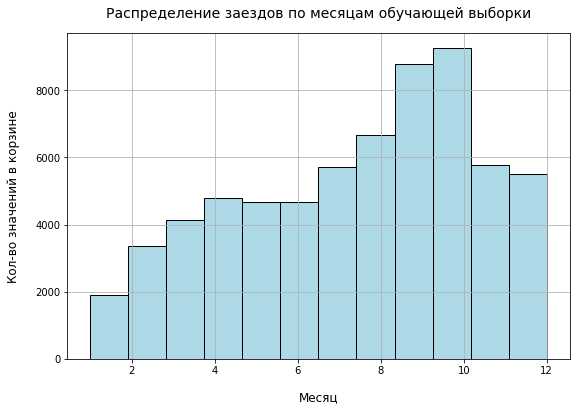

In [30]:
get_hist_unequal_features(data_train, 'arrival_date_month', 12)
plt.title('Распределение заездов по месяцам обучающей выборки', fontsize=14, pad=15)
plt.xlabel('Месяц', fontsize=12, labelpad=15);

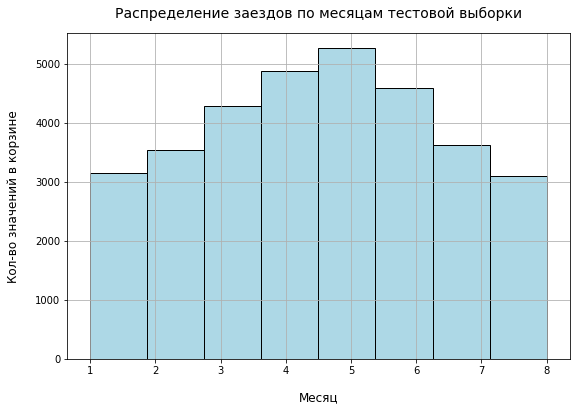

In [31]:
get_hist_unequal_features(data_test, 'arrival_date_month', 8)
plt.title('Распределение заездов по месяцам тестовой выборки', fontsize=14, pad=15)
plt.xlabel('Месяц', fontsize=12, labelpad=15);

**Вывод:** кол-во месяцев в выборках не совпадают, так же они имеют разное распределение нужного периода (с 1 по 8 месяц): пик кол-ва броней в обучающей приходится на август, а в тестовой - на май. Так же по обучающей выборке видно, что клиенты для заезда в отель предпочитают месяцы сентябрь и октябрь.

**Неделя заезда**

In [32]:
data_train.arrival_date_week_number.nunique()

53

In [33]:
data_test.arrival_date_week_number.nunique()

35

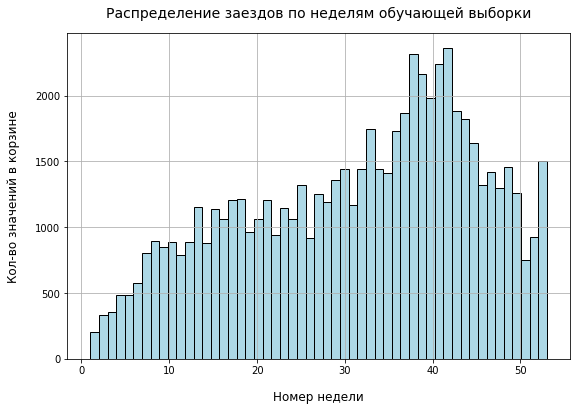

In [34]:
get_hist_unequal_features(data_train, 'arrival_date_week_number', 53)
plt.title('Распределение заездов по неделям обучающей выборки', fontsize=14, pad=15)
plt.xlabel('Номер недели', fontsize=12, labelpad=15);

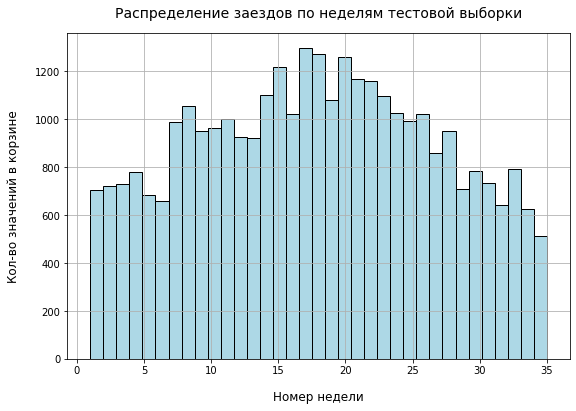

In [35]:
get_hist_unequal_features(data_test, 'arrival_date_week_number', 35)
plt.title('Распределение заездов по неделям тестовой выборки', fontsize=14, pad=15)
plt.xlabel('Номер недели', fontsize=12, labelpad=15);

**Вывод:** кол-во недель в выборках не совпадает, распределения заездов по неделям имееют тот же самый вид, что и распределения заездов по месяцам.

In [36]:
data_train[['arrival_date_month', 'arrival_date_week_number']].phik_matrix()

interval columns not set, guessing: ['arrival_date_month', 'arrival_date_week_number']


,arrival_date_month,arrival_date_week_number
arrival_date_month,1.000000,0.977463
arrival_date_week_number,0.977463,1.000000


Между номером недели и номером месяца есть прямая зависимость, они практически идентичны, для дальнейшей корректной работы модели следует удалить один из столбцов.

In [37]:
data_train.drop('arrival_date_week_number', axis=1, inplace=True)
data_test.drop('arrival_date_week_number', axis=1, inplace=True)

In [38]:
data_train.reset_index(drop=True, inplace=True )
data_test.reset_index(drop=True, inplace=True )

**День заезда**

In [39]:
data_train.arrival_date_day_of_month.nunique()

31

In [40]:
data_test.arrival_date_day_of_month.nunique()

31

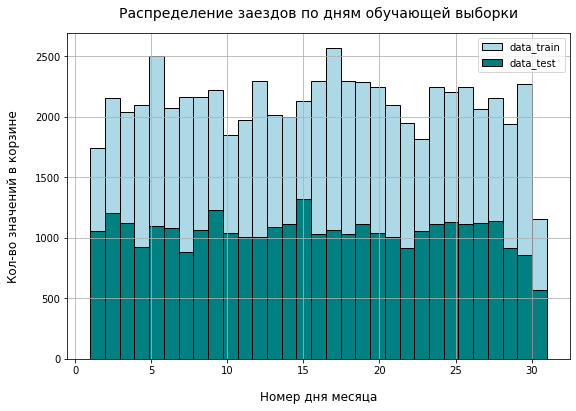

In [41]:
get_hist_equal_features('arrival_date_day_of_month', 31)
plt.title('Распределение заездов по дням обучающей выборки', fontsize=14, pad=15)
plt.xlabel('Номер дня месяца', fontsize=12, labelpad=15);

**Вывод:** заезды по дням в обоих датасетах распределены практически равномерно, есть небольшие пики заездов 5 и 17 числа в обучающей выборке и 2, 9 и 15 - в тестовой.

Удалим этот столбец

In [42]:
data_train.drop('arrival_date_day_of_month', axis=1, inplace=True)
data_test.drop('arrival_date_day_of_month', axis=1, inplace=True)

#### Исследование категориальных признаков

В таблице данных есть 5 столбцов с категориальными переменными.

**Небольшой обзор**

In [43]:
print(
    'Train:', data_train.meal.unique(),
    'Test:', data_test.meal.unique(), 
    sep='\n'
)

Train:
['BB       ' 'FB       ' 'HB       ' 'SC       ' 'SC']
Test:
['BB       ' 'HB       ' 'SC' 'FB       ' 'SC       ']


In [44]:
print(
    'Train:', data_train.country.unique(),
    'Test:', data_test.country.unique(), 
    sep='\n'
)

Train:
['GBR' 'PRT' 'ESP' 'IRL' 'FRA' 'ROU' 'NOR' 'USA' 'DEU' 'BEL' 'CHE' 'CN'
 'GRC' 'NLD' 'ARG' 'RUS' 'SWE' 'POL' 'EST' 'CZE' 'ITA' 'FIN' 'DNK' 'MOZ'
 'BWA' 'LUX' 'BRA' 'SVN' 'ALB' 'CHN' 'MEX' 'MAR' 'SMR' 'LVA' 'CHL' 'AUT'
 'LTU' 'TUR' 'ISR' 'IND' 'CYM' 'AUS' 'CPV' 'ZWE' 'DZA' 'KOR' 'CRI' 'HUN'
 'TUN' 'ARE' 'HRV' 'HKG' 'IRN' 'GIB' 'JEY' 'URY' 'ZAF' 'COL' 'GGY' 'KWT'
 'CYP' 'KAZ' 'THA' 'DOM' 'NGA' 'BLR' 'VEN' 'UKR' 'ARM' 'JPN' 'LKA' 'MYS'
 'BIH' 'MUS' 'OMN' 'SUR' 'JAM' 'BGR' 'CIV' 'SRB' 'JOR' 'SYR' 'PHL' 'PRI'
 'SGP' 'BDI' 'LBN' 'AGO' 'VNM' 'AZE' 'PLW' 'NZL' 'EGY' 'MDV' 'CMR' 'MLT'
 'SVK' 'MWI' 'STP' 'TWN' 'IDN' 'SEN' 'PER' 'SAU' 'KNA' 'ETH' 'ECU' 'IRQ'
 'AND' 'HND' 'PAK' 'GEO' 'ZMB' 'QAT' 'KHM' 'MCO' 'BGD' 'ISL' 'UZB' 'IMN'
 'TJK' 'NIC' 'BEN' 'MAC' 'VGB' 'TZA' 'GAB' 'MKD' 'TMP' 'GLP' 'KEN' 'LIE'
 'MMR' 'PAN' 'BFA' 'LBY' 'GNB' 'MLI' 'BHR' 'NAM' 'BOL' 'SYC' 'PRY' 'BRB'
 'ABW' 'SLV' 'DMA' 'CUB' 'PYF' 'UGA' 'GUY' 'LCA' 'ATA' 'RWA' 'MNE']
Test:
['PRT' 'AUT' 'BEL' 'DEU' 'BRA' 'GBR' 'ESP' '

In [45]:
print(
    'Train:', data_train.distribution_channel.unique(),
    'Test:', data_test.distribution_channel.unique(), 
    sep='\n'
)

Train:
['Direct' 'TA/TO' 'Corporate' 'GDS']
Test:
['TA/TO' 'Direct' 'Corporate' 'GDS']


In [46]:
print(
    'train:', data_train.reserved_room_type.unique(),
    'test:', data_test.reserved_room_type.unique(), 
    sep='\n'
)

train:
['A               ' 'C               ' 'D               '
 'E               ' 'G               ' 'F               '
 'B               ']
test:
['A               ' 'E               ' 'G               '
 'D               ' 'F               ' 'C               '
 'B               ']


In [47]:
print(
    'Train:', data_train.customer_type.unique(),
    'Test:', data_test.customer_type.unique(), 
    sep='\n'
)

Train:
['Transient' 'Contract' 'Transient-Party' 'Group']
Test:
['Transient' 'Transient-Party' 'Contract' 'Group']


В значениях столбцов с опциями заказа и типом забронированной комнаты есть лишние пробелы, их необходимо удалить.

In [48]:
data_train[['meal', 'reserved_room_type']] = data_train[['meal', 'reserved_room_type']].replace(
    ' ', '', regex = True)
data_test[['meal', 'reserved_room_type']] = data_test[['meal', 'reserved_room_type']].replace(
    ' ', '', regex = True)

In [49]:
print(
    'train:', data_train.reserved_room_type.unique(),
    'test:', data_test.reserved_room_type.unique(), 
    sep='\n'
)

train:
['A' 'C' 'D' 'E' 'G' 'F' 'B']
test:
['A' 'E' 'G' 'D' 'F' 'C' 'B']


In [50]:
print(
    'train:', data_train.meal.unique(),
    'test:', data_test.meal.unique(), 
    sep='\n'
)

train:
['BB' 'FB' 'HB' 'SC']
test:
['BB' 'HB' 'SC' 'FB']


In [51]:
data_train.country.value_counts().head(15).sum() / data_train.country.count() * 100

91.43939045516565

Так как уникальных значений гражданства в обучающей выборке слишком много и при этом там отсутствуют некоторые значения, которые есть в тестовой выборке, оставим топ 15 стран-гражданств, которые покрывают более 90% данных, остальные заменим на `other`.

In [52]:
df_country = data_train.country.value_counts().head(15).to_frame(name='count')

df_country.reset_index(inplace=True)
df_country.drop('count', axis=1, inplace=True)
df_country.columns = ['country']

df_country

,country
0,PRT
1,FRA
2,GBR
3,ESP
4,DEU
5,ITA
6,IRL
7,BEL
8,NLD
9,BRA


In [53]:
def change_country(row):
    if row.country in df_country.country.unique():
        return row.country
    else:
        return 'other'

In [54]:
data_train['country'] = data_train.apply(change_country, axis=1)
data_test['country'] = data_test.apply(change_country, axis=1)

Проверим

In [55]:
data_train.country.nunique()

16

In [56]:
data_test.country.nunique()

16

___

**Опции заказа**

- `SC` — нет дополнительных опций;
- `BB` — включён завтрак;
- `HB` — включён завтрак и обед;
- `FB` — включён завтрак, обед и ужин.

In [57]:
data_train.meal.value_counts()

BB    51697
HB     7292
SC     5789
FB      451
Name: meal, dtype: int64

In [58]:
data_test.meal.value_counts()

BB    24684
SC     5293
HB     2399
FB       36
Name: meal, dtype: int64

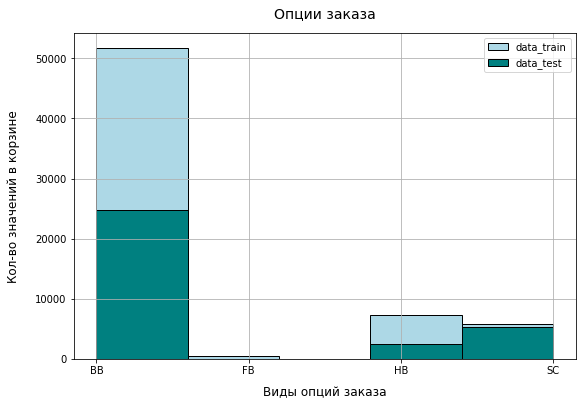

In [59]:
get_hist_equal_features('meal', 5)
plt.title('Опции заказа', fontsize=14, pad=15)
plt.xlabel('Виды опций заказа', fontsize=12, labelpad=10);

**Вывод:** большинство клиентов дополнительно включают в свой заказ завтрак, очень малое кол-во людей включают и завтрак, и обед, и ужин. Так же стоит отметить, что в обучающей выборке на втором месте по популярности стоит опция по добавлению завтрака и обеда, а в тестовой - не выбирают ничего.

**Канал дистрибуции заказа**

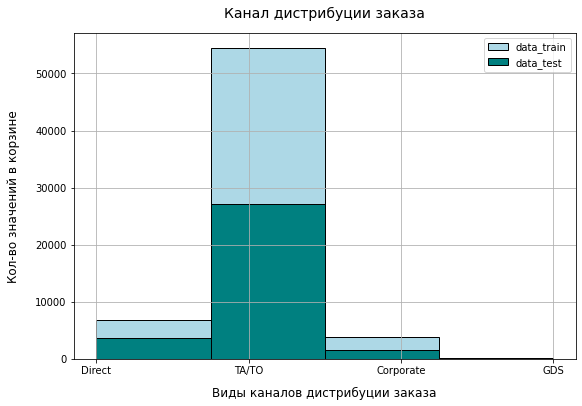

In [60]:
get_hist_equal_features('distribution_channel', 4)
plt.title('Канал дистрибуции заказа', fontsize=14, pad=15)
plt.xlabel('Виды каналов дистрибуции заказа', fontsize=12, labelpad=10);

**Вывод:** самый популярный канал дистрибуции заказа `ТА/ТО`, наименее - `GDS`.

**Тип забронированной комнаты**

В отеле есть несколько типов комнат:
- категория `A`: стоимость за ночь — 1 000;
- категория `B`: стоимость за ночь — 800;
- категория `C`: стоимость за ночь — 600;
- категория `D`: стоимость за ночь — 550;
- категория `E`: стоимость за ночь — 500;
- категория `F`: стоимость за ночь — 450;
- категория `G`: стоимость за ночь — 350.

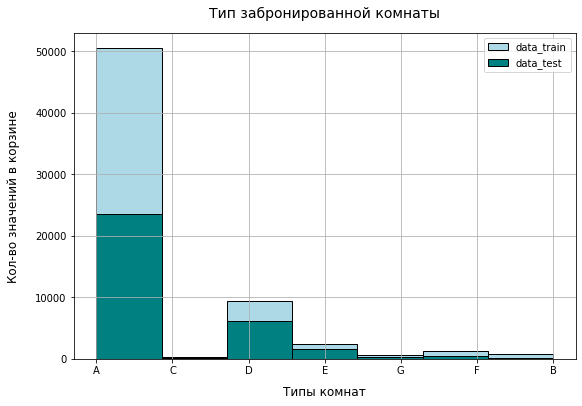

In [61]:
get_hist_equal_features('reserved_room_type', 7)
plt.title('Тип забронированной комнаты', fontsize=14, pad=15)
plt.xlabel('Типы комнат', fontsize=12, labelpad=10);

**Вывод:** больше всего бронируют комнаты типа `А` - самый дорогой вариант, меньше всего - комнаты типа `В`, `C`, `F` и `G`. На втором месте находится комната типа и `D`.

**Тип заказчика**

- `Contract` — договор с юридическим лицом;
- `Group` — групповой заезд;
- `Transient` — не связано с договором или групповым заездом;
- `Transient-party` — не связано с договором или групповым заездом, но связано с бронированием типа Transient.

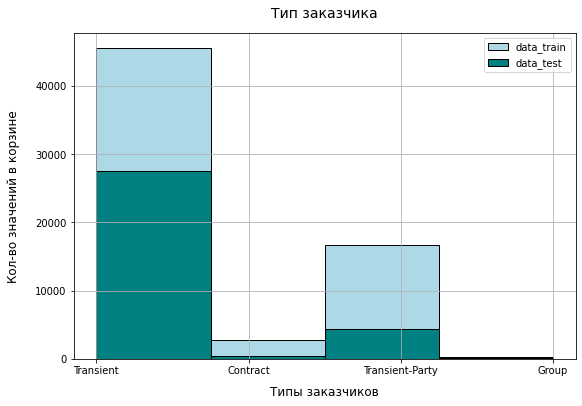

In [62]:
get_hist_equal_features('customer_type', 4)
plt.title('Тип заказчика', fontsize=14, pad=15)
plt.xlabel('Типы заказчиков', fontsize=12, labelpad=10);

**Вывод:** большинство клиентов не связано с договором или групповым заездом, чуть меньше - не связано с договором или групповым заездом, но связано с бронированием типа `Transient`. Меньше всего клиентов группового заезда.

**Гражданство постояльца**

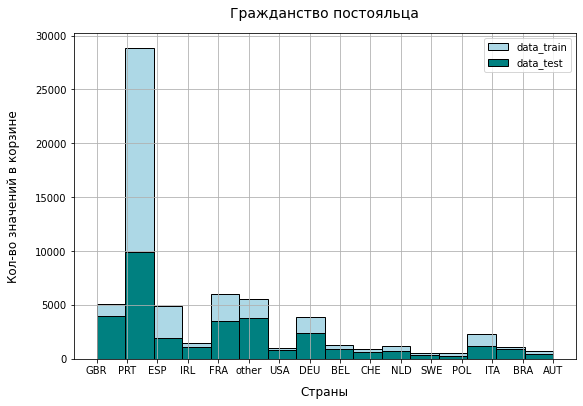

In [63]:
get_hist_equal_features('country', 16)
plt.title('Гражданство постояльца', fontsize=14, pad=15)
plt.xlabel('Страны', fontsize=12, labelpad=10);

**Вывод:** клиенты отеля имеют 155 национальностей, больше всего в обоих выборках португальцев. На втором месте в обучающей - Франция, в тестовой - Великобритания.

#### Исследование количественных переменных

Номер заказа не несет информации, влияющей на отмену заказа, его можно удалить. 

In [64]:
data_train.drop('id', axis=1, inplace=True)
data_test.drop('id', axis=1, inplace=True)

In [65]:
def get_boxplot(feature):
    data = [data_train[feature], data_test[feature]]
    labels = ['Train', 'Test']
    plt.figure(figsize=(9, 6))
    plt.grid(True)
    plt.boxplot(data, labels=labels)

**Отмена заказа**

In [66]:
print(
    'Train:', sorted(data_train.is_canceled.unique()),
    'Test:', sorted(data_test.is_canceled.unique()), 
    sep='\n'
)

Train:
[0, 1]
Test:
[0, 1]


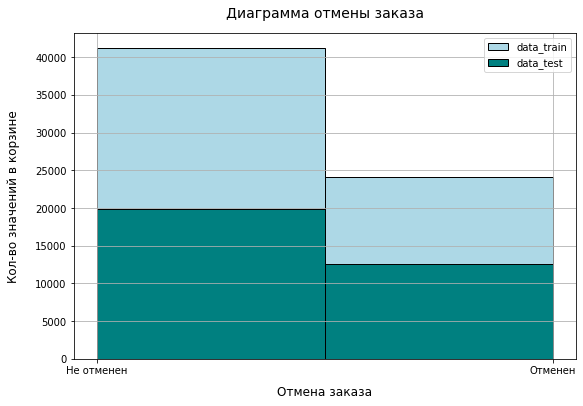

In [67]:
get_hist_equal_features('is_canceled', 2)
plt.title('Диаграмма отмены заказа', fontsize=14, pad=15)
plt.xlabel('Отмена заказа', fontsize=12, labelpad=10)
plt.xticks(ticks=[0, 1], labels=['Не отменен', 'Отменен']);

**Вывод:** в обоих датасетах в колонке с отменой заказа содержатся одинаковые уникальные значения. Так же в обоих выборках не отмененных заказов больше, чем отмененных.

**Признак того, что гость бронирует номер второй раз**

In [68]:
print(
    'Train:', sorted(data_train.is_repeated_guest.unique()),
    'Test:', sorted(data_test.is_repeated_guest.unique()), 
    sep='\n'
)

Train:
[0, 1]
Test:
[0, 1]


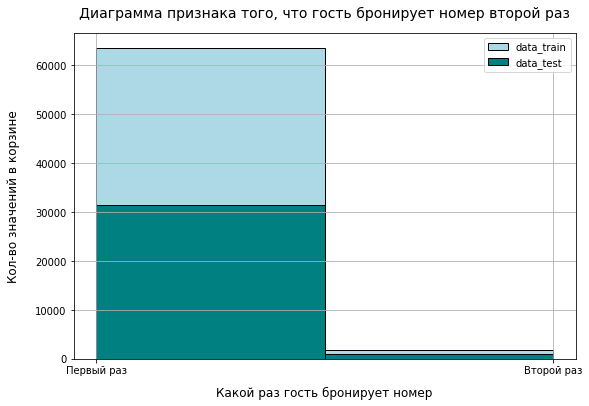

In [69]:
get_hist_equal_features('is_repeated_guest', 2)
plt.title('Диаграмма признака того, что гость бронирует номер второй раз', fontsize=14, pad=15)
plt.xlabel('Какой раз гость бронирует номер', fontsize=12, labelpad=10)
plt.xticks(ticks=[0, 1], labels=['Первый раз', 'Второй раз']);

**Вывод:** в обоих датасетах в колонке с признаком того, что гость бронирует номер второй раз содержатся одинаковые уникальные значения. Так же в обоих выборках больше тех клиентов, которые бронируют номер первый раз.

**Количество ночей в выходные дни**

In [70]:
print(
    'Train:', sorted(data_train.stays_in_weekend_nights.unique()),
    'Test:', sorted(data_test.stays_in_weekend_nights.unique()), 
    sep='\n'
)

Train:
[0, 1, 2, 3, 4]
Test:
[0, 1, 2, 3, 4]


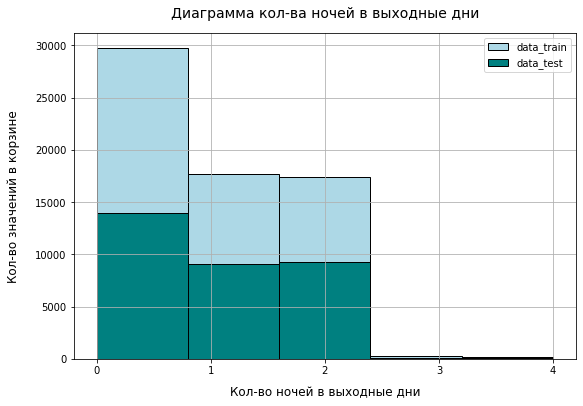

In [71]:
get_hist_equal_features('stays_in_weekend_nights', 5)
plt.title('Диаграмма кол-ва ночей в выходные дни', fontsize=14, pad=15)
plt.xlabel('Кол-во ночей в выходные дни', fontsize=12, labelpad=10)
plt.xticks(ticks=[0, 1, 2, 3, 4]);

**Вывод:** в обоих датасетах в колонке с кол-вом ночей в выходные дни содержатся одинаковые уникальные значения. Так же в обоих выборках больше тех клиентов, которые остаются в выходные на ночь либо на 1, либо на 2 дня.

**Количество ночей в будние дни**

In [72]:
print(
    'Train:', sorted(data_train.stays_in_week_nights.unique()),
    'Test:', sorted(data_test.stays_in_week_nights.unique()), 
    sep='\n'
)

Train:
[0, 1, 2, 3, 4, 5, 6]
Test:
[0, 1, 2, 3, 4, 5, 6]


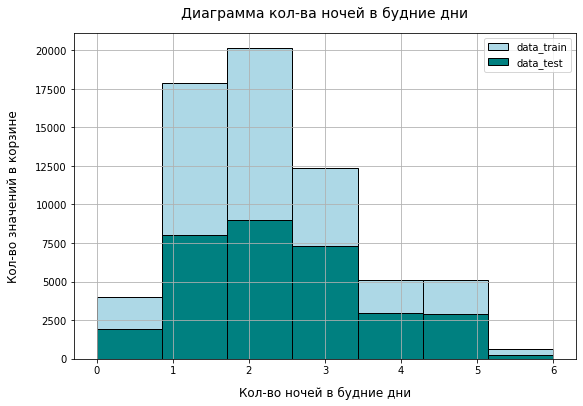

In [73]:
get_hist_equal_features('stays_in_week_nights', 7)
plt.title('Диаграмма кол-ва ночей в будние дни', fontsize=14, pad=15)
plt.xlabel('Кол-во ночей в будние дни', fontsize=12, labelpad=10);

**Вывод:** в обоих датасетах в колонке с кол-вом ночей в будние дни содержатся одинаковые уникальные значения. Так же в обоих выборках в будние дни клиенты чаще остаются на 1, 2 или 3 дня.

**Общее количество ночей**

In [74]:
print(
    'Train:', sorted(data_train.total_nights.unique()),
    'Test:', sorted(data_test.total_nights.unique()), 
    sep='\n'
)

Train:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Test:
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


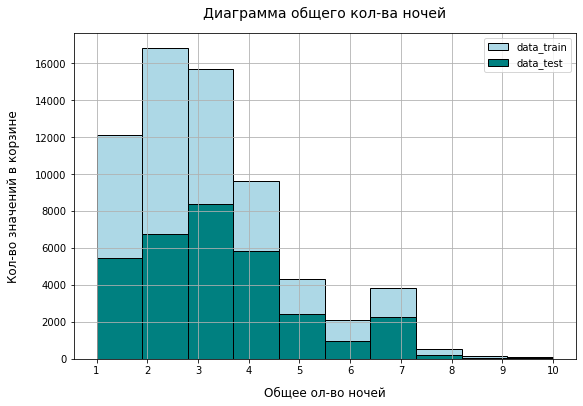

In [75]:
get_hist_equal_features('total_nights', 10)
plt.title('Диаграмма общего кол-ва ночей', fontsize=14, pad=15)
plt.xlabel('Общее ол-во ночей', fontsize=12, labelpad=10)
plt.xticks(ticks=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]);

**Вывод:** в обоих датасетах в колонке с общим кол-вом ночей содержатся одинаковые уникальные значения. Так же в обоих выборках клиенты чаще всего остаются на 1, 2, 3 или 4 ночи.

In [76]:
data_train[['stays_in_weekend_nights', 'stays_in_week_nights', 'total_nights']].phik_matrix()

interval columns not set, guessing: ['stays_in_weekend_nights', 'stays_in_week_nights', 'total_nights']


,stays_in_weekend_nights,stays_in_week_nights,total_nights
stays_in_weekend_nights,1.000000,0.476435,0.937393
stays_in_week_nights,0.476435,1.000000,0.856009
total_nights,0.937393,0.856009,1.000000


Так как столбцы со значениями кол-ва ночей в будни, кол-ва ночей в выходные дни и общего кол-ва ночей имеют между собой большую зависимость, для дальнейшей корректной работы моделей, следует оставить только столбец с общим кол-вом ночей. 

In [77]:
data_train.drop('stays_in_weekend_nights', axis=1, inplace=True)
data_test.drop('stays_in_weekend_nights', axis=1, inplace=True)

In [78]:
data_train.drop('stays_in_week_nights', axis=1, inplace=True)
data_test.drop('stays_in_week_nights', axis=1, inplace=True)

In [79]:
data_train.reset_index(drop=True, inplace=True )
data_test.reset_index(drop=True, inplace=True )

**Необходимость места для автомобиля**

In [80]:
print(
    'Train:', sorted(data_train.required_car_parking_spaces.unique()),
    'Test:', sorted(data_test.required_car_parking_spaces.unique()), 
    sep='\n'
)

Train:
[0, 1, 2, 3]
Test:
[0, 1, 2, 3, 8]


In [81]:
data_train.required_car_parking_spaces.value_counts()

0    61547
1     3670
2       11
3        1
Name: required_car_parking_spaces, dtype: int64

In [82]:
data_test.required_car_parking_spaces.value_counts()

0    30935
1     1468
2        6
8        2
3        1
Name: required_car_parking_spaces, dtype: int64

Необходимость места для авто подразумевает ответ либо "да" равное 1, либо "нет" равное 0, таким образом, отметки 2, 3 и 8 можно считать выбросами или ошибкой оператора. Можно исправить эту ошибку преобразовав этот признак в бинарный, заменим эти значения на 1 что будет считаться что место для парковки клиенту необходимо

In [83]:
data_train.loc[data_train.required_car_parking_spaces > 1, 'required_car_parking_spaces'] = 1

In [84]:
data_test.loc[data_test.required_car_parking_spaces > 1, 'required_car_parking_spaces'] = 1

Проверим

In [85]:
data_train.required_car_parking_spaces.value_counts()

0    61547
1     3682
Name: required_car_parking_spaces, dtype: int64

In [86]:
data_test.required_car_parking_spaces.value_counts()

0    30935
1     1477
Name: required_car_parking_spaces, dtype: int64

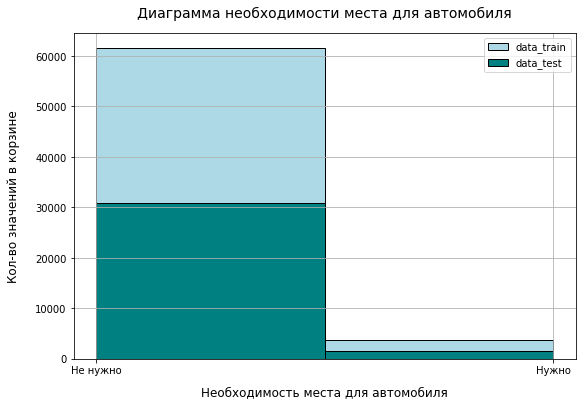

In [87]:
get_hist_equal_features('required_car_parking_spaces', 2)
plt.title('Диаграмма необходимости места для автомобиля', fontsize=14, pad=15)
plt.xlabel('Необходимость места для автомобиля', fontsize=12, labelpad=10)
plt.xticks(ticks=[0, 1], labels=['Не нужно', 'Нужно']);

**Вывод:** большинство клиентов не нуждается в парковочном месте.

**Количество взрослых постояльцев**

In [88]:
print(
    'Train:', sorted(data_train.adults.unique()),
    'Test:', sorted(data_test.adults.unique()), 
    sep='\n'
)

Train:
[0, 1, 2, 3, 4]
Test:
[0, 1, 2, 3, 4]


In [89]:
data_train.adults.value_counts()

2    48980
1    13212
3     2858
0      166
4       13
Name: adults, dtype: int64

In [90]:
data_test.adults.value_counts()

2    24237
1     6280
3     1817
0       69
4        9
Name: adults, dtype: int64

В обоих датасетах есть значения равные 0, сомневаюсь что заселится в отель мог несовершеннолетний, так как название колонки подразумевает кол-во именно заселившихся взрослых, возможно это ошибка. Таких значений не так много, поэтому можно заменить их на 1.

In [91]:
data_train.adults.median()

2.0

In [92]:
data_train.loc[data_train.adults == 0, 'adults'] = 2

In [93]:
data_test.loc[data_test.adults == 0, 'adults'] = 2

Проверяем:

In [94]:
data_train.adults.value_counts()

2    49146
1    13212
3     2858
4       13
Name: adults, dtype: int64

In [95]:
data_test.adults.value_counts()

2    24306
1     6280
3     1817
4        9
Name: adults, dtype: int64

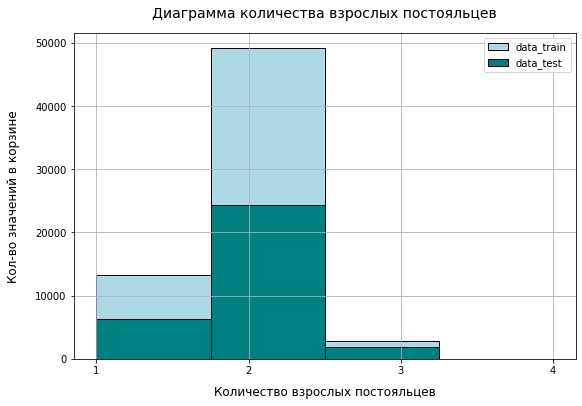

In [96]:
get_hist_equal_features('adults', 4)
plt.title('Диаграмма количества взрослых постояльцев', fontsize=14, pad=15)
plt.xlabel('Количество взрослых постояльцев', fontsize=12, labelpad=10)
plt.xticks(ticks=[1, 2, 3, 4]);

**Вывод:** в обоих датасетах в колонке с кол-вом взрослых постояльцев содержатся одинаковые уникальные значения. В обоих датасетах кол-во взрослых постояльцев чаще всего равно 2 или 1.

**Количество детей от 3 до 14 лет**

In [97]:
print(
    'Train:', sorted(data_train.children.unique()),
    'Test:', sorted(data_test.children.unique()), 
    sep='\n'
)

Train:
[0, 1, 2, 3]
Test:
[0, 1, 2, 3]


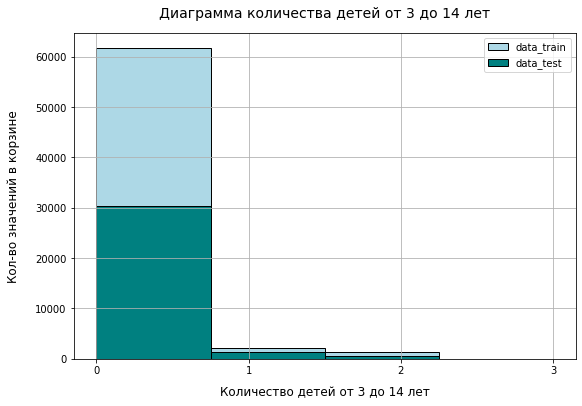

In [98]:
get_hist_equal_features('children', 4)
plt.title('Диаграмма количества детей от 3 до 14 лет', fontsize=14, pad=15)
plt.xlabel('Количество детей от 3 до 14 лет', fontsize=12, labelpad=10)
plt.xticks(ticks=[0, 1, 2, 3]);

**Вывод:** в обоих датасетах в колонке с кол-вом детей от 3 до 14 лет содержатся одинаковые уникальные значения. Так же значения в обоих выборках говорят о том, что чаще всего гости засляются без детей от 3 до 14 лет. 

**Количество младенцев**

In [99]:
print(
    'Train:', sorted(data_train.babies.unique()),
    'Test:', sorted(data_test.babies.unique()), 
    sep='\n'
)

Train:
[0, 1, 2, 9, 10]
Test:
[0, 1, 2]


In [100]:
data_train.babies.value_counts()

0     64777
1       447
2         3
9         1
10        1
Name: babies, dtype: int64

В обучающей выборке в столбце с кол-вом младенцев есть два значения-аномалии: 9 и 10, таких всего 2, их следует удалить.

In [101]:
data_train = data_train.query('babies < 9')

In [102]:
data_train.reset_index(drop= True , inplace= True )

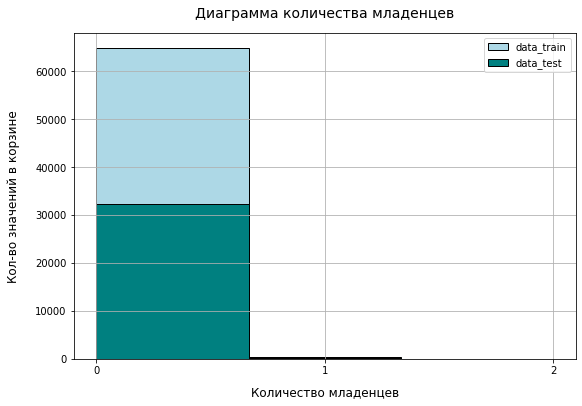

In [103]:
get_hist_equal_features('babies', 3)
plt.title('Диаграмма количества младенцев', fontsize=14, pad=15)
plt.xlabel('Количество младенцев', fontsize=12, labelpad=10)
plt.xticks(ticks=[0, 1, 2]);

**Вывод:** чаще всего взрослые клиенты заселяются без младенцев.

**Количество дней между датой бронирования и датой прибытия**

In [104]:
print(
    'Train:', data_train.lead_time.nunique(),
    'Test:', data_test.lead_time.nunique(), 
    sep='\n'
)

Train:
369
Test:
368


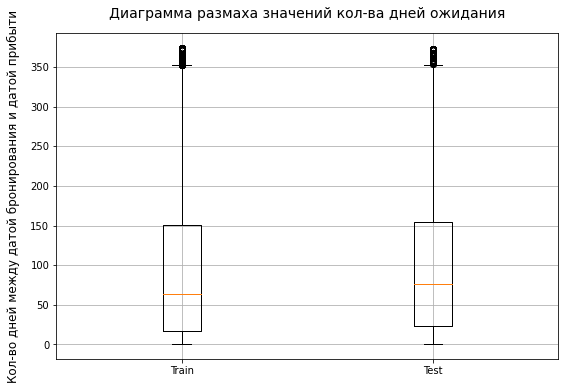

In [105]:
get_boxplot('lead_time')
plt.title('Диаграмма размаха значений кол-ва дней ожидания', fontsize=14, pad=15)
plt.ylabel('Кол-во дней между датой бронирования и датой прибыти', fontsize=12, labelpad=10);

In [106]:
q1, q3 = np.percentile(data_train.lead_time, [25, 75])
iqr = q3 - q1
q3 + iqr * 1.5

352.0

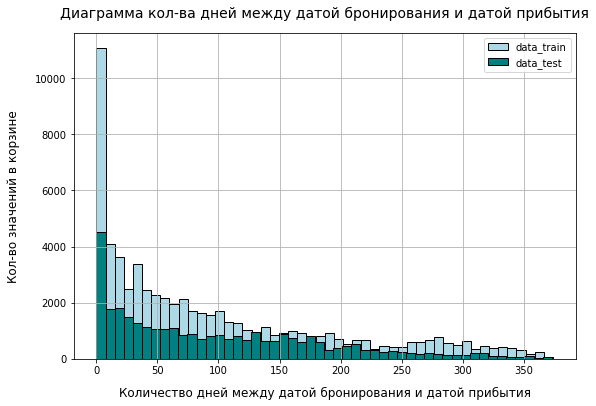

In [107]:
get_hist_equal_features('lead_time', 50)
plt.title('Диаграмма кол-ва дней между датой бронирования и датой прибытия', fontsize=14, pad=15)
plt.xlabel('Количество дней между датой бронирования и датой прибытия', fontsize=12, labelpad=10);

**Вывод:** диаграммы количества дней между датой бронирования и датой прибытия обучающей и тестовой выборки имеют похожие распределения, чаще всего клиенты бронируют номера примерно за месяц до прибытия.

**Количество отменённых заказов у клиента**

In [108]:
print(
    'Train:', sorted(data_train.previous_cancellations.unique()),
    'Test:', sorted(data_test.previous_cancellations.unique()), 
    sep='\n'
)

Train:
[0, 1, 2, 3, 4, 5, 6, 11, 13, 14, 19, 21, 24, 25, 26]
Test:
[0, 1, 2, 3, 4, 5, 6]


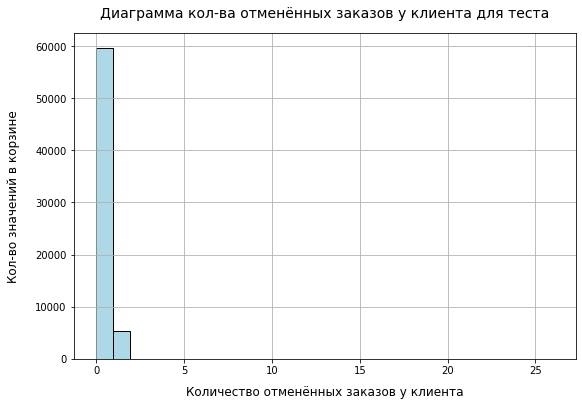

In [109]:
get_hist_unequal_features(data_train, 'previous_cancellations', 27)
plt.title('Диаграмма кол-ва отменённых заказов у клиента для теста', fontsize=14, pad=15)
plt.xlabel('Количество отменённых заказов у клиента', fontsize=12, labelpad=10);

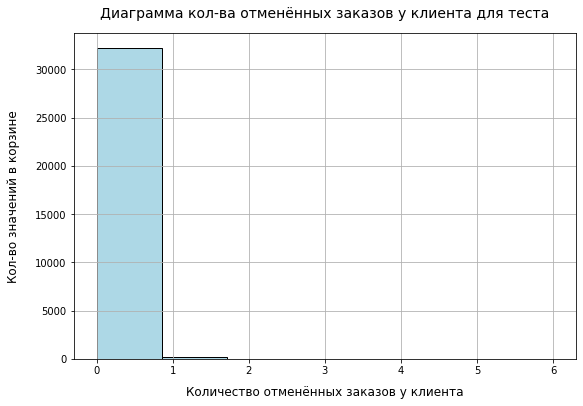

In [110]:
get_hist_unequal_features(data_test, 'previous_cancellations', 7)
plt.title('Диаграмма кол-ва отменённых заказов у клиента для теста', fontsize=14, pad=15)
plt.xlabel('Количество отменённых заказов у клиента', fontsize=12, labelpad=10);

**Вывод:** в обоих выборках чаще всего клиенты не отменяют заказы.

**Количество подтверждённых заказов у клиента**

In [111]:
print(
    'Train:', sorted(data_train.previous_bookings_not_canceled.unique()),
    'Test:', sorted(data_test.previous_bookings_not_canceled.unique()), 
    sep='\n'
)

Train:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58]
Test:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72]


Количество подтверждённых заказов у клиента больших 30 достаточно мало, их можно удалить без потерь для данных.

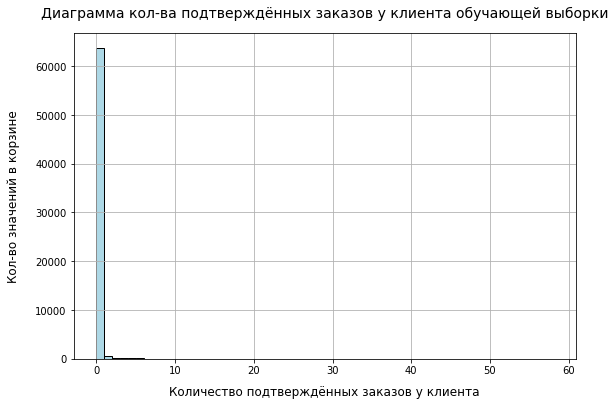

In [112]:
get_hist_unequal_features(data_train, 'previous_bookings_not_canceled', 58)
plt.title('Диаграмма кол-ва подтверждённых заказов у клиента обучающей выборки', fontsize=14, pad=15)
plt.xlabel('Количество подтверждённых заказов у клиента', fontsize=12, labelpad=10);

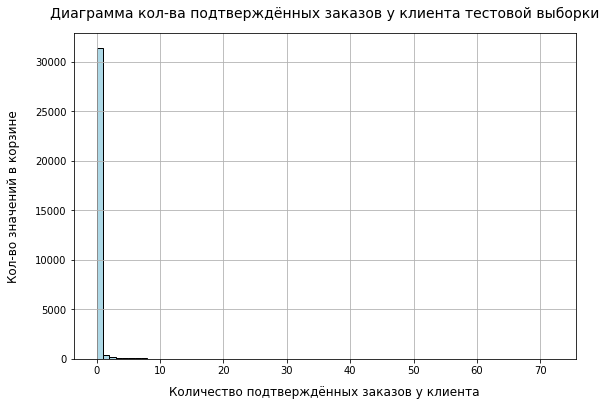

In [113]:
get_hist_unequal_features(data_test, 'previous_bookings_not_canceled', 72)
plt.title('Диаграмма кол-ва подтверждённых заказов у клиента тестовой выборки', fontsize=14, pad=15)
plt.xlabel('Количество подтверждённых заказов у клиента', fontsize=12, labelpad=10);

**Вывод:** большинство клиентов в базе не имеют подтвержденных заказов, возможно это связано с тем, что клиенты новые или название столбца неправильно интерпретировано.

**Сколько дней заказ ожидал подтверждения**

In [114]:
print(
    'Train:', sorted(data_train.days_in_waiting_list.unique()),
    'Test:', sorted(data_test.days_in_waiting_list.unique()), 
    sep='\n'
)

Train:
[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 17, 19, 20, 21, 22, 24, 25, 27, 28, 30, 31, 32, 33, 34, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 53, 55, 56, 57, 58, 59, 60, 61, 62, 63, 65, 68, 69, 70, 71, 72, 74, 75, 76, 77, 79, 80, 81, 85, 87, 89, 91, 93, 96, 98, 99, 101, 107, 108, 111, 120, 122, 125, 142, 147, 150, 160, 162, 167, 174, 176, 178, 187, 193, 207, 215, 224, 236, 259]
Test:
[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 20, 21, 22, 23, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 38, 39, 43, 44, 46, 47, 49, 50, 53, 54, 56, 57, 59, 60, 61, 63, 64, 65, 71, 73, 76, 80, 83, 84, 93, 98, 99, 100, 105, 107, 109, 111, 113, 117, 121, 122, 154, 165, 175, 183, 185, 223]


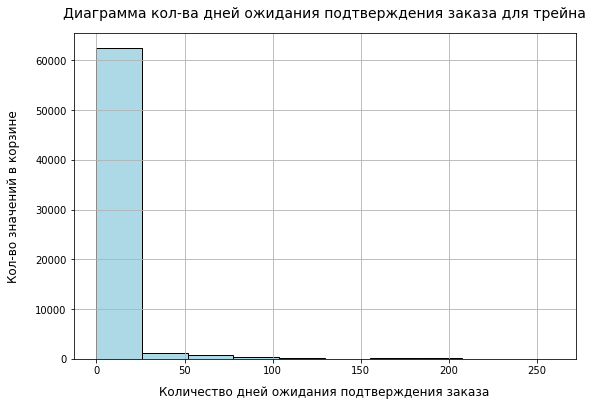

In [115]:
get_hist_unequal_features(data_train, 'days_in_waiting_list', 10)
plt.title('Диаграмма кол-ва дней ожидания подтверждения заказа для трейна', fontsize=14, pad=15)
plt.xlabel('Количество дней ожидания подтверждения заказа', fontsize=12, labelpad=10);

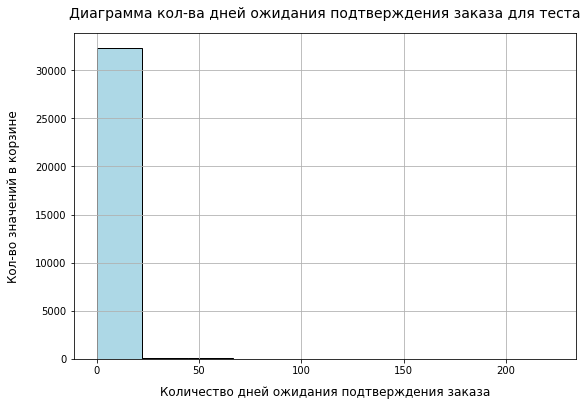

In [116]:
get_hist_unequal_features(data_test, 'days_in_waiting_list', 10)
plt.title('Диаграмма кол-ва дней ожидания подтверждения заказа для теста', fontsize=14, pad=15)
plt.xlabel('Количество дней ожидания подтверждения заказа', fontsize=12, labelpad=10);

**Вывод:** в обоих выборках заказ подтверждается в основном в первые сутки после бронирования, про остальные значения сказать сложно, возмозжно из-за технических неполадок заказ обрабатывался слишком долго.

**Количество изменений параметров заказа**

In [117]:
print(
    'Train:', sorted(data_train.booking_changes.unique()),
    'Test:', sorted(data_test.booking_changes.unique()), 
    sep='\n'
)

Train:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 14, 15, 16, 17]
Test:
[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 14, 15, 16, 18]


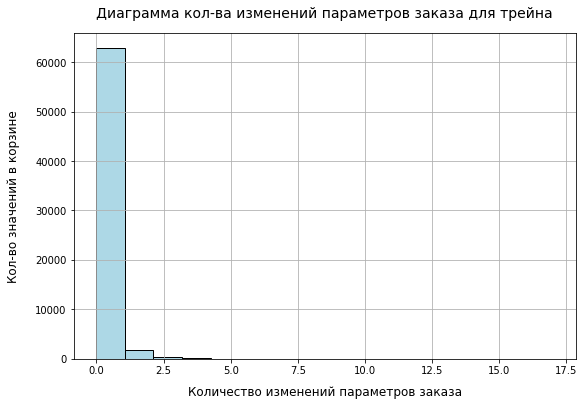

In [118]:
get_hist_unequal_features(data_train, 'booking_changes', 16)
plt.title('Диаграмма кол-ва изменений параметров заказа для трейна', fontsize=14, pad=15)
plt.xlabel('Количество изменений параметров заказа', fontsize=12, labelpad=10);

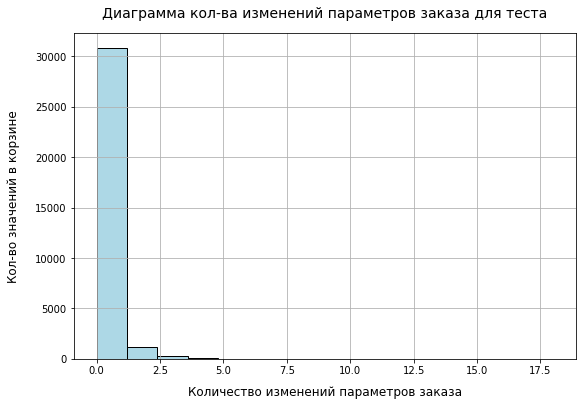

In [119]:
get_hist_unequal_features(data_test, 'booking_changes', 15)
plt.title('Диаграмма кол-ва изменений параметров заказа для теста', fontsize=14, pad=15)
plt.xlabel('Количество изменений параметров заказа', fontsize=12, labelpad=10);

**Вывод:** в обоих датасетах клиенты в основном не меняют параметры брони.

**Количество специальных отметок**

In [120]:
print(
    'Train:', sorted(data_train.total_of_special_requests.unique()),
    'Test:', sorted(data_test.total_of_special_requests.unique()), 
    sep='\n'
)

Train:
[0, 1, 2, 3, 4, 5]
Test:
[0, 1, 2, 3, 4, 5]


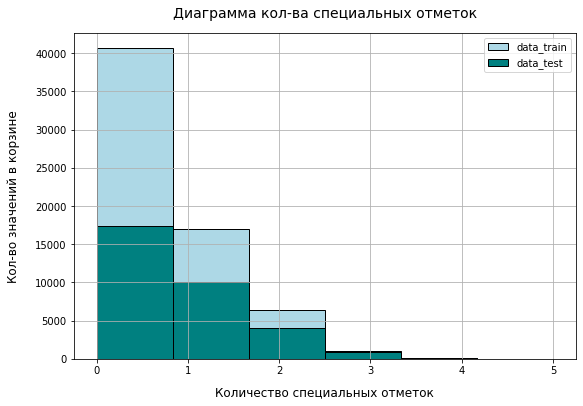

In [121]:
get_hist_equal_features('total_of_special_requests', 6)
plt.title('Диаграмма кол-ва специальных отметок', fontsize=14, pad=15)
plt.xlabel('Количество специальных отметок', fontsize=12, labelpad=10);

**Вывод:** в обоих выборках большинство клиентов не имеют специальных отметок, у чуть меньшего кол-во клиентов есть либо 1, либо 2.

#### Исследование зависимостей целевого признака

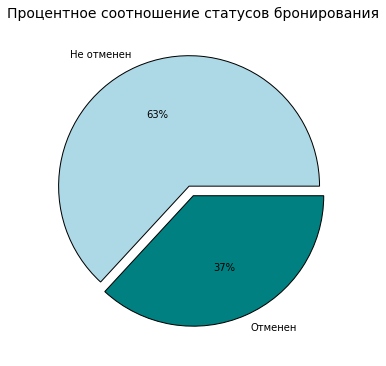

In [122]:
plt.figure(figsize=(9,6)) 
plt.pie(data_train.is_canceled.value_counts(normalize=True), 
        labels=['Не отменен', 'Отменен'],
        autopct='%.0f%%',
        explode=(0.08, 0),
        wedgeprops={'edgecolor': 'k'},
        colors=['lightblue', 'teal'])
plt.title('Процентное соотношение статусов бронирования', fontsize=14, pad=15);

В данных есть дисбаланс классов, не отмененных заказов больше практически в 1.5 раза, при этом доля отмененных заказов составила чуть меньше 40%, это значит, что в среднем 3-4 заказа из 10 будут отменены.

In [123]:
data_train.phik_matrix()

interval columns not set, guessing: ['is_canceled', 'lead_time', 'arrival_date_month', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'required_car_parking_spaces', 'total_of_special_requests', 'total_nights']


,is_canceled,lead_time,arrival_date_month,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
is_canceled,1.000000,0.429841,0.088348,0.116210,0.046692,0.019168,0.088042,0.497765,0.250159,0.062724,0.068036,0.054606,0.081540,0.078787,0.175398,0.150795,0.289208,0.410640,0.187750
lead_time,0.429841,1.000000,0.433002,0.211482,0.074291,0.030939,0.197106,0.247107,0.261824,0.202866,0.107716,0.072556,0.140154,0.042026,0.390202,0.246380,0.169347,0.159382,0.404344
arrival_date_month,0.088348,0.433002,1.000000,0.165518,0.093610,0.028813,0.125800,0.168624,0.105812,0.082676,0.074282,0.072304,0.074613,0.036280,0.266618,0.172773,0.046424,0.102494,0.190656
adults,0.116210,0.211482,0.165518,1.000000,0.145878,0.032820,0.169716,0.214610,0.426839,0.261933,0.065647,0.114778,0.281119,0.040837,0.069135,0.189700,0.020139,0.174396,0.201415
children,0.046692,0.074291,0.093610,0.145878,1.000000,0.026084,0.090471,0.119584,0.108221,0.043512,0.000000,0.000000,0.511040,0.065980,0.042129,0.138514,0.074627,0.130351,0.050063
babies,0.019168,0.030939,0.028813,0.032820,0.026084,1.000000,0.015391,0.031778,0.035080,0.006940,0.000000,0.000000,0.069872,0.082527,0.007171,0.021929,0.022006,0.326185,0.044988
meal,0.088042,0.197106,0.125800,0.169716,0.090471,0.015391,1.000000,0.295781,0.202574,0.091293,0.240490,0.024099,0.141429,0.000000,0.080618,0.335584,0.064083,0.101576,0.175312
country,0.497765,0.247107,0.168624,0.214610,0.119584,0.031778,0.295781,1.000000,0.193900,0.190304,0.117617,0.049961,0.194200,0.092191,0.183093,0.190791,0.124704,0.244332,0.282165
distribution_channel,0.250159,0.261824,0.105812,0.426839,0.108221,0.035080,0.202574,0.193900,1.000000,0.457030,0.155675,0.218557,0.162524,0.071605,0.077526,0.204185,0.203434,0.122808,0.234837
is_repeated_guest,0.062724,0.202866,0.082676,0.261933,0.043512,0.006940,0.091293,0.190304,0.457030,1.000000,0.278641,0.471186,0.043819,0.000000,0.037198,0.102651,0.096301,0.065849,0.182380


interval columns not set, guessing: ['is_canceled', 'lead_time', 'arrival_date_month', 'adults', 'children', 'babies', 'is_repeated_guest', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'required_car_parking_spaces', 'total_of_special_requests', 'total_nights']


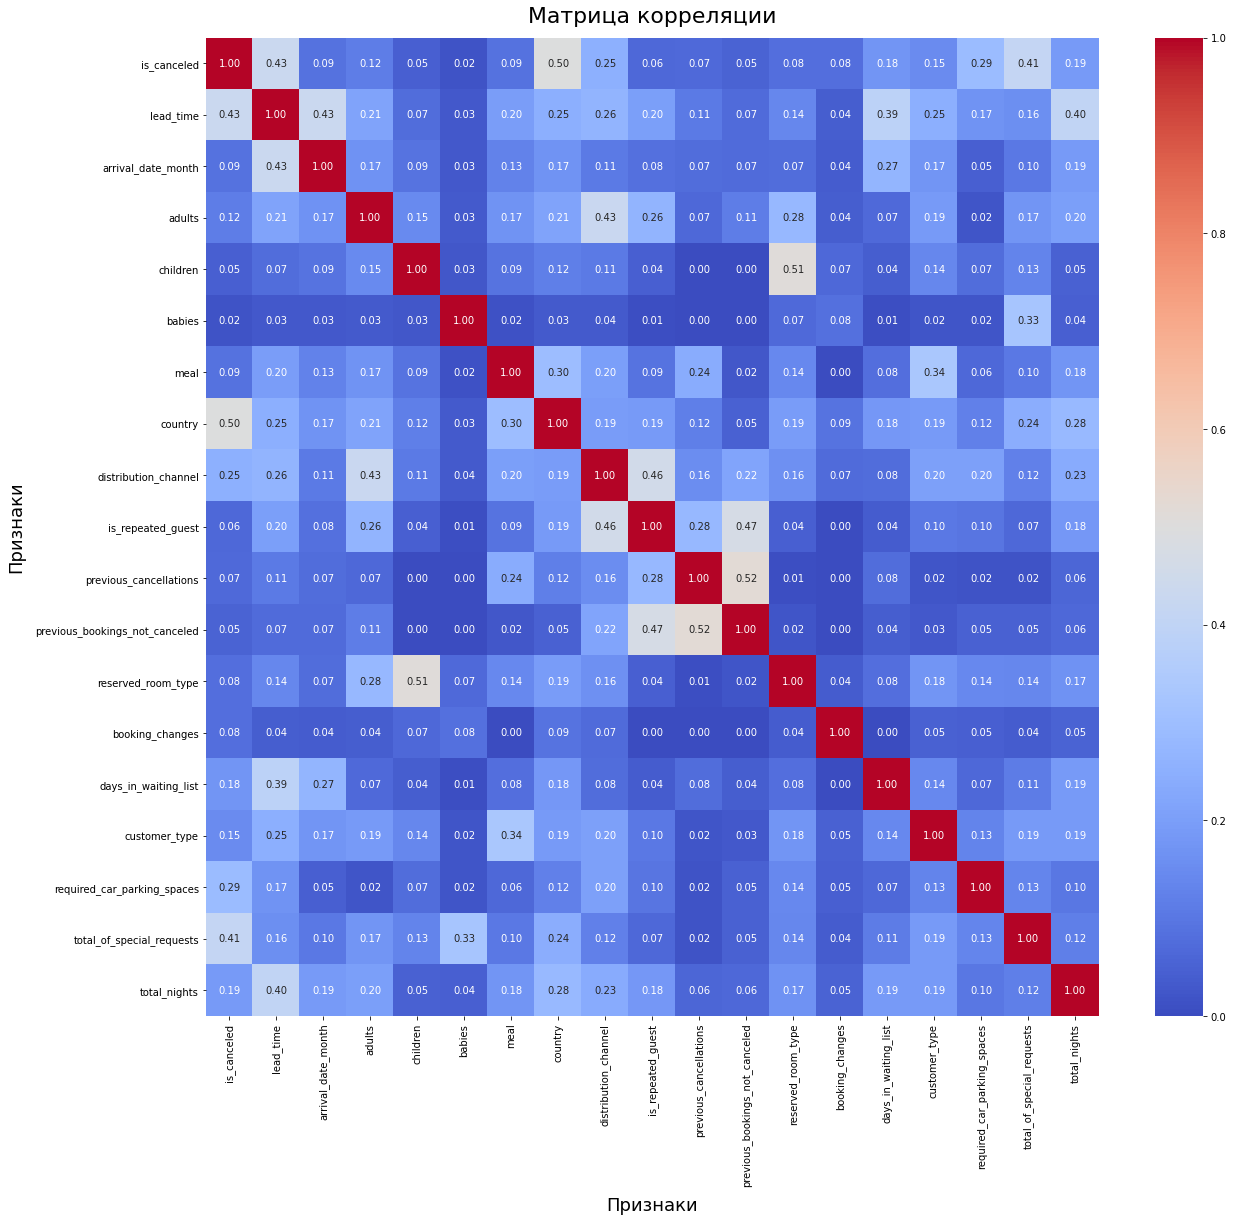

In [125]:
plt.figure(figsize = (20,18))
sns.heatmap(
            data_train.phik_matrix(), 
            cmap='coolwarm',
            annot=True,
            fmt='.2f'
);
plt.title('Матрица корреляции', fontsize=22, pad=15)
plt.xlabel('Признаки', fontsize=18, labelpad=10)
plt.ylabel('Признаки', fontsize=18, labelpad=10);

Наибольшее влияние на отмену заказа в обучающей выборке оказывают следующие признаки:
- `country` - гражданство постояльца;
- `distribution_channel` - канал дистрибуции заказа;
- `total_nights` - общее количество ночей;
- `customer_type` - тип заказчика;
- `adults` - количество взрослых постояльцев;

- `days_in_waiting_list` - сколько дней заказ ожидал подтверждения;
- `lead_time` - количество дней между датой бронирования и датой прибытия;
- `required_car_parking_spaces` - необходимость места для автомобиля;
- `total_of_special_requests` - количество специальных отметок.

___

In [126]:
def get_bar_of_dependence(feature):
    (data_train
    .pivot_table(index='is_canceled', values=feature, aggfunc='mean')
    .plot(kind='bar',
          figsize=(9, 6),
          color='teal')
    )
    plt.grid(True)
    plt.xlabel('Статус заказа', fontsize=12, labelpad = 10)
    plt.xticks(ticks=[0, 1], labels=['Не отменен', 'Отменен']);

**Сколько дней заказ ожидал подтверждения**

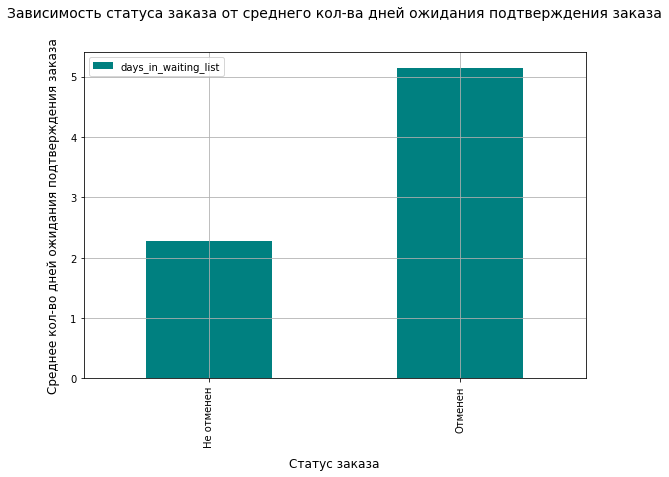

In [127]:
get_bar_of_dependence('days_in_waiting_list')
plt.title('Зависимость статуса заказа от среднего кол-ва дней ожидания подтверждения заказа', 
          fontsize=14, pad=35)
plt.ylabel('Среднее кол-во дней ожидания подтверждения заказа', fontsize=12, labelpad = 10);

**Вывод:** в среднем клиент готов ждать 2 дня, если приходится ждать больше, около 5 дней, он отменяет заказ. Чем больше ожидание подтверждения заказа, тем вероятнее, что он будет отменен. 

**Количество дней между датой бронирования и датой прибытия**

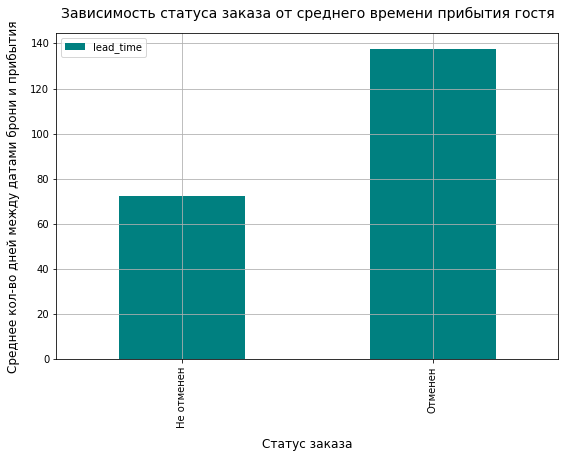

In [128]:
get_bar_of_dependence('lead_time')
plt.title('Зависимость статуса заказа от среднего времени прибытия гостя', fontsize=14, pad=15)
plt.ylabel('Среднее кол-во дней между датами брони и прибытия', fontsize=12, labelpad = 10);

**Вывод:** чем больше дней пройдет между дататой бронирования номера и приездом гостя, тем более вероятно, что гость отменит заказ. В среднем не отменяют заказ при бронировании за 2.5 месяца, отменяют - за 4.5 месяца.

**Количество отменённых заказов у клиента**

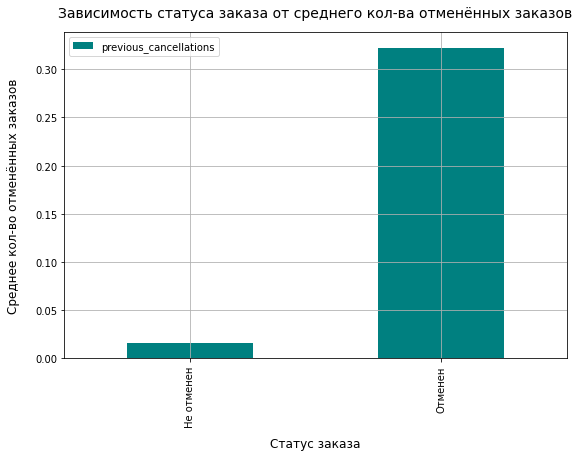

In [129]:
get_bar_of_dependence('previous_cancellations')
plt.title('Зависимость статуса заказа от среднего кол-ва отменённых заказов', fontsize=14, pad=15)
plt.ylabel('Среднее кол-во отменённых заказов', fontsize=12, labelpad = 15);

**Вывод:** чем больше гость отменял заказов, тем вероятнее что и в этот раз он опять отменит заказ. 

**Количество изменений параметров заказа**

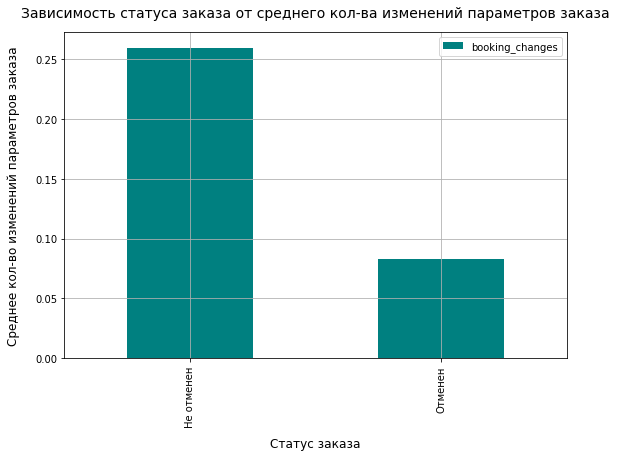

In [130]:
get_bar_of_dependence('booking_changes')
plt.title('Зависимость статуса заказа от среднего кол-ва изменений параметров заказа', fontsize=14, pad=15)
plt.ylabel('Среднее кол-во изменений параметров заказа', fontsize=12, labelpad = 15);

**Вывод:** если клиент вносит изменения в бронирование, вероятнее всего он не отменит заказ.

**Необходимость места для автомобиля**

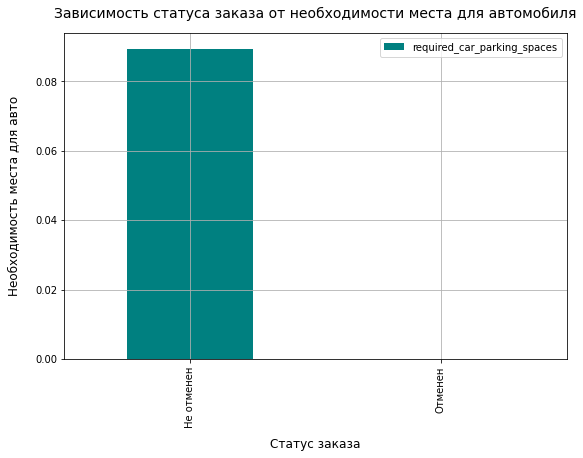

In [131]:
get_bar_of_dependence('required_car_parking_spaces')
plt.title('Зависимость статуса заказа от необходимости места для автомобиля', fontsize=14, pad=15)
plt.ylabel('Необходимость места для авто', fontsize=12, labelpad = 15);

**Вывод:** большинство клиентов не нуждается в парковочном месте, однако, если клиент забронировал вместе с номером местом для авто, вероятнее всего он не отменит бронь.

**Количество специальных отметок**

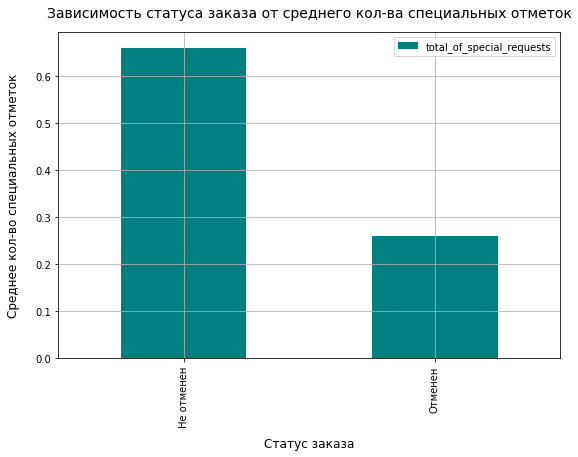

In [132]:
get_bar_of_dependence('total_of_special_requests')
plt.title('Зависимость статуса заказа от среднего кол-ва специальных отметок', fontsize=14, pad=15)
plt.ylabel('Среднее кол-во специальных отметок', fontsize=12, labelpad = 15);

**Вывод:** в среднем, чем больше отметок у клиента, тем вероятнее что он не отменит бронь (это могут быть постоянные клиенты).

**Гражданство постояльца**

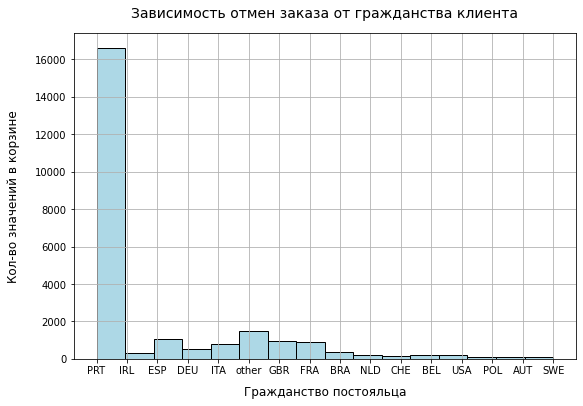

In [133]:
get_hist_unequal_features(data_train[data_train.is_canceled == 1], 'country', 16)
plt.title('Зависимость отмен заказа от гражданства клиента', fontsize=14, pad=15)
plt.xlabel('Гражданство постояльца', fontsize=12, labelpad=10);

**Вывод:** больше всего отмен делают португальцы, однако их в целом больше среди посетителей отеля

**Канал дистрибуции заказа**

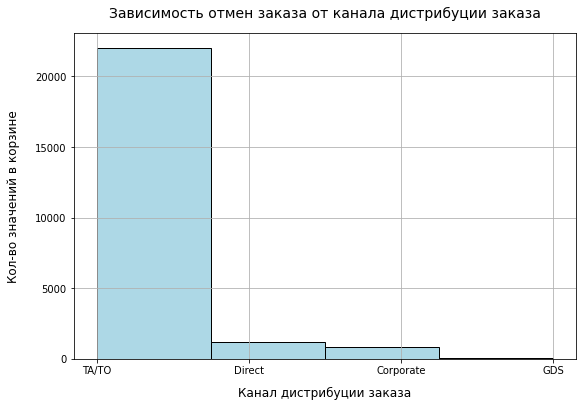

In [134]:
get_hist_unequal_features(data_train[data_train.is_canceled == 1], 'distribution_channel', 4)
plt.title('Зависимость отмен заказа от канала дистрибуции заказа', fontsize=14, pad=15)
plt.xlabel('Канал дистрибуции заказа', fontsize=12, labelpad=10);

**Вывод:** больше всех отменяют заказы клиенты, канал дистрибуции заказа которых является `TA/TO`, однако, клиентов с этим каналом в целом больше.

**Общее количество ночей**

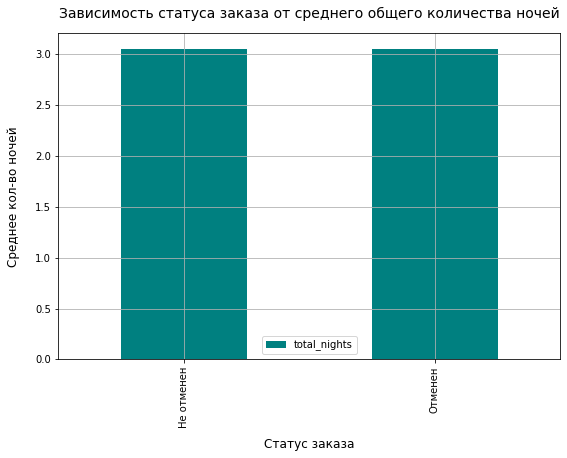

In [135]:
get_bar_of_dependence('total_nights')
plt.title('Зависимость статуса заказа от среднего общего количества ночей', fontsize=14, pad=15)
plt.ylabel('Среднее кол-во ночей', fontsize=12, labelpad = 15);

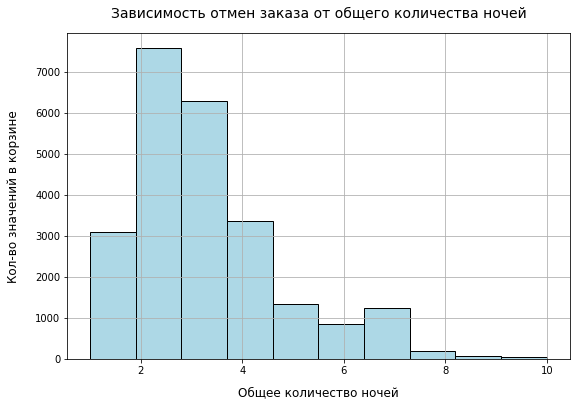

In [136]:
get_hist_unequal_features(data_train[data_train.is_canceled == 1], 'total_nights', 10)
plt.title('Зависимость отмен заказа от общего количества ночей', fontsize=14, pad=15)
plt.xlabel('Общее количество ночей', fontsize=12, labelpad=10);

**Вывод:** в среднем практически нет разницы между тем на сколько остается гость и отменяет заказ, либо нет. Но чаще всего отменяют заказы клиенты, которые решили остаться на 2-3 дня.

**Тип заказчика**

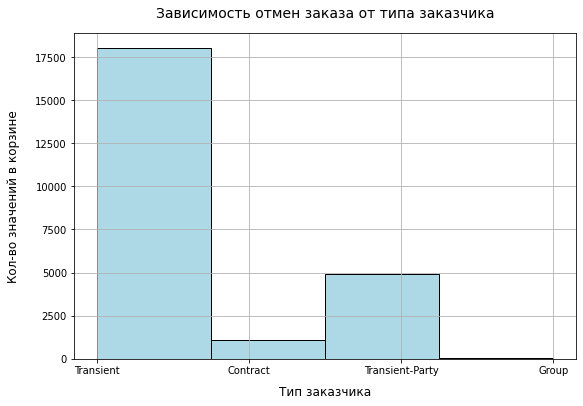

In [137]:
get_hist_unequal_features(data_train[data_train.is_canceled == 1], 'customer_type', 4)
plt.title('Зависимость отмен заказа от типа заказчика', fontsize=14, pad=15)
plt.xlabel('Тип заказчика', fontsize=12, labelpad=10);

**Вывод:** чаще всего отменяет бронь клиент типа `Transient`

**Количество взрослых постояльцев**

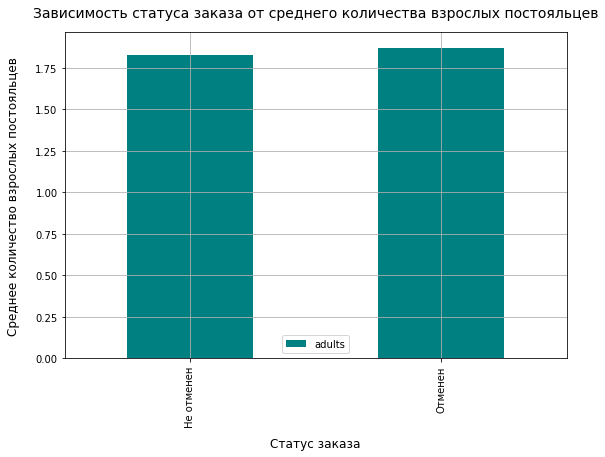

In [138]:
get_bar_of_dependence('adults')
plt.title('Зависимость статуса заказа от среднего количества взрослых постояльцев', fontsize=14, pad=15)
plt.ylabel('Среднее количество взрослых постояльцев', fontsize=12, labelpad = 15);

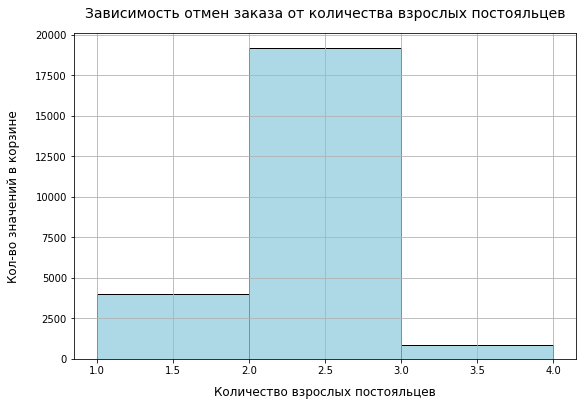

In [139]:
get_hist_unequal_features(data_train[data_train.is_canceled == 1], 'adults', 3)
plt.title('Зависимость отмен заказа от количества взрослых постояльцев', fontsize=14, pad=15)
plt.xlabel('Количество взрослых постояльцев', fontsize=12, labelpad=10);

**Вывод:** чаще всего отменяют заказы клиенты с 2 взрослыми, но таких клиентов вцелом больше.

#### Кодирование и масштабирование

In [140]:
# Сохраним некоторые значения тестовой выборки для дальнейшей работы с подсчетом выручки
data_test_reserved_room_type = data_test[['reserved_room_type']]
data_test_arrival_date_month = data_test[['arrival_date_month']]
data_test_total_nights = data_test[['total_nights']]

In [141]:
category_features = data_train.select_dtypes(include='object').columns.to_list()
category_features.append('arrival_date_month')
print('category:', category_features, sep='\n')

num_features = data_train.select_dtypes(exclude='object').columns.to_list()
num_features.remove('is_canceled')
num_features.remove('is_repeated_guest')
num_features.remove('required_car_parking_spaces')
num_features.remove('arrival_date_month')
print('num:', num_features, sep='\n')

category:
['meal', 'country', 'distribution_channel', 'reserved_room_type', 'customer_type', 'arrival_date_month']
num:
['lead_time', 'adults', 'children', 'babies', 'previous_cancellations', 'previous_bookings_not_canceled', 'booking_changes', 'days_in_waiting_list', 'total_of_special_requests', 'total_nights']


In [142]:
col_transformer = make_column_transformer(
    (
        OneHotEncoder(drop='first', handle_unknown='ignore'),
        category_features
    ),
    (
        StandardScaler(), 
        num_features
    ),
    remainder='passthrough',
    verbose_feature_names_out=False
)

data_train = pd.DataFrame(
    col_transformer.fit_transform(data_train),
    columns=col_transformer.get_feature_names_out()
)

data_train.head()

,meal_FB,meal_HB,meal_SC,country_BEL,country_BRA,country_CHE,country_DEU,country_ESP,country_FRA,country_GBR,...,babies,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,total_of_special_requests,total_nights,is_canceled,is_repeated_guest,required_car_parking_spaces
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.083075,-0.133549,-0.081194,-0.327107,-0.182816,-0.681330,-1.179435,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-0.083075,-0.133549,-0.081194,-0.327107,-0.182816,0.647413,-0.604099,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.083075,-0.133549,-0.081194,-0.327107,-0.182816,-0.681330,-0.604099,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.083075,-0.133549,-0.081194,-0.327107,-0.182816,0.647413,-0.604099,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.083075,-0.133549,-0.081194,-0.327107,-0.182816,0.647413,-0.028764,1.0,0.0,0.0


In [143]:
data_test = pd.DataFrame(
    col_transformer.transform(data_test),
    columns=col_transformer.get_feature_names_out()
)

data_test.head()

,meal_FB,meal_HB,meal_SC,country_BEL,country_BRA,country_CHE,country_DEU,country_ESP,country_FRA,country_GBR,...,babies,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,total_of_special_requests,total_nights,is_canceled,is_repeated_guest,required_car_parking_spaces
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.083075,-0.133549,-0.081194,-0.327107,-0.182816,-0.681330,-1.179435,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.083075,-0.133549,-0.081194,-0.327107,-0.182816,0.647413,0.546572,1.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.083075,-0.133549,-0.081194,-0.327107,-0.182816,0.647413,0.546572,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.083075,-0.133549,-0.081194,-0.327107,-0.182816,0.647413,0.546572,1.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-0.083075,-0.133549,-0.081194,-0.327107,-0.182816,-0.681330,2.272578,1.0,0.0,0.0


#### Матрица корреляции

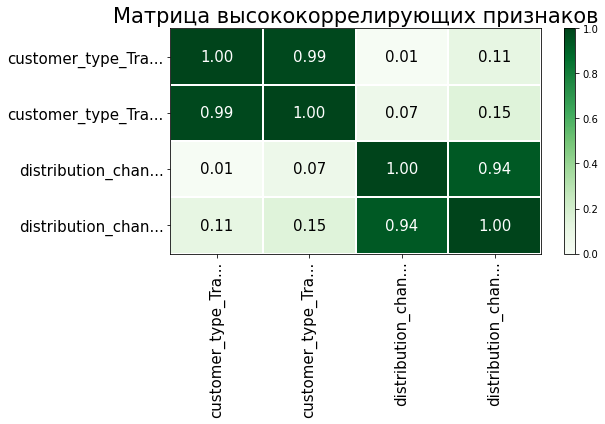

In [144]:
interval_cols = [
    'lead_time', 'adults', 'children', 
    'babies', 'previous_cancellations', 
    'previous_bookings_not_canceled', 
    'booking_changes', 'days_in_waiting_list', 
    'total_of_special_requests', 'total_nights'
]

df_phik_matrix = data_train.phik_matrix(interval_cols=interval_cols)

no_md_matrix = pd.DataFrame(
                            df_phik_matrix.mask(np.eye(df_phik_matrix.shape[0], dtype = bool)), 
                            columns=df_phik_matrix.columns
)
corr_features = [col for col in no_md_matrix.columns if no_md_matrix[col].max() >= 0.9]
phik_high_corr = df_phik_matrix.loc[corr_features][corr_features]

plot_correlation_matrix(
    phik_high_corr.values, 
    x_labels=phik_high_corr.columns, 
    y_labels=phik_high_corr.index, 
    vmin=0, 
    vmax=1, 
    color_map='Greens', 
    title='Матрица высококоррелирующих признаков', 
    fontsize_factor=1.5, 
    figsize=(9, 6)
)

**Вывод:** после предобработки высокую зависимость имеют столбцы `x0_Transient` и `x0_Transient-Party`, `x0_Direct` и `x0_TA/TO`.

### Шаг 3. Формулировка ML-задачи на основе бизнес-задачи

Основная бизнес-метрика для любой сети отелей — её прибыль. Прибыль отеля — это разница между стоимостью номера за все ночи и затраты на обслуживание: как при подготовке номера, так и при проживании постояльца. 

В отеле есть несколько типов номеров. В зависимости от типа номера назначается стоимость за одну ночь. Есть также затраты на уборку. Если клиент снял номер надолго, то убираются каждые два дня. 

Стоимость номеров отеля:
- категория A: за ночь — 1 000, разовое обслуживание — 400;
- категория B: за ночь — 800, разовое обслуживание — 350;
- категория C: за ночь — 600, разовое обслуживание — 350;
- категория D: за ночь — 550, разовое обслуживание — 150;
- категория E: за ночь — 500, разовое обслуживание — 150;
- категория F: за ночь — 450, разовое обслуживание — 150;
- категория G: за ночь — 350, разовое обслуживание — 150.

В ценовой политике отеля используются сезонные коэффициенты: весной и осенью цены повышаются на 20%, летом — на 40%.
Убытки отеля в случае отмены брони номера — это стоимость одной уборки и одной ночи с учётом сезонного коэффициента.

На разработку системы прогнозирования заложен бюджет — 400 000. При этом необходимо учесть, что внедрение модели должно окупиться за тестовый период. Затраты на разработку должны быть меньше той выручки, которую система принесёт компании.

Нужно разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку. Деньги будут списаны со счёта клиента, если он всё же отменит бронь.

Составим сводные таблицы:

In [146]:
name_room = pd.Series(['A', 'B', 'C', 'D', 'E', 'F', 'G']).to_frame(name='reserved_room_type')
price_room = pd.Series([1000, 800, 600, 550, 500, 450, 350]).to_frame(name='price_room')
price_clining = pd.Series([400, 350, 350, 150, 150, 150, 150]).to_frame(name='price_clining')

data_pricing = pd.concat([name_room, price_room, price_clining], axis= 1)

In [147]:
data_pricing

,reserved_room_type,price_room,price_clining
0,A,1000,400
1,B,800,350
2,C,600,350
3,D,550,150
4,E,500,150
5,F,450,150
6,G,350,150


In [148]:
month = pd.Series([1, 2, 3, 4, 5, 6, 7, 8]).to_frame(name='arrival_date_month')
season_k = pd.Series([1, 1, 1.2, 1.2, 1.2, 1.4, 1.4, 1.4]).to_frame(name='season_k')

data_season_k = pd.concat([month, season_k], axis= 1)

In [149]:
data_season_k

,arrival_date_month,season_k
0,1,1.0
1,2,1.0
2,3,1.2
3,4,1.2
4,5,1.2
5,6,1.4
6,7,1.4
7,8,1.4


Подготовим датасет для вычисления выручки:

In [150]:
data_test_is_canceled = data_test[['is_canceled']]

In [151]:
data_test_price_before = pd.concat(
    [data_test_is_canceled, data_test_reserved_room_type, data_test_arrival_date_month, data_test_total_nights],
    axis=1
)

In [152]:
data_test_price_before.head()

,is_canceled,reserved_room_type,arrival_date_month,total_nights
0,1.0,A,1,1
1,1.0,A,1,4
2,1.0,A,1,4
3,1.0,A,1,4
4,1.0,A,1,7


In [153]:
data_test_price_before.isna().sum()

is_canceled           0
reserved_room_type    0
arrival_date_month    0
total_nights          0
dtype: int64

In [154]:
data_test_price_before = pd.merge(data_test_price_before, data_pricing, how='left', on='reserved_room_type')

In [155]:
data_test_price_before = pd.merge(data_test_price_before, data_season_k, how='left', on='arrival_date_month')

In [156]:
data_test_price_before.head()

,is_canceled,reserved_room_type,arrival_date_month,total_nights,price_room,price_clining,season_k
0,1.0,A,1,1,1000,400,1.0
1,1.0,A,1,4,1000,400,1.0
2,1.0,A,1,4,1000,400,1.0
3,1.0,A,1,4,1000,400,1.0
4,1.0,A,1,7,1000,400,1.0


Проверим корректность присоединения:

In [157]:
data_test_price_before.isna().sum()

is_canceled           0
reserved_room_type    0
arrival_date_month    0
total_nights          0
price_room            0
price_clining         0
season_k              0
dtype: int64

Посчитаем выручку каждого заказа:

In [158]:
data_test_price_before['income_before'] = np.nan

In [159]:
data_test_price_before.head()

,is_canceled,reserved_room_type,arrival_date_month,total_nights,price_room,price_clining,season_k,income_before
0,1.0,A,1,1,1000,400,1.0,NaN
1,1.0,A,1,4,1000,400,1.0,NaN
2,1.0,A,1,4,1000,400,1.0,NaN
3,1.0,A,1,4,1000,400,1.0,NaN
4,1.0,A,1,7,1000,400,1.0,NaN


In [160]:
def get_income_before(row):
    if row.is_canceled == 0:
        income = row.price_room * row.season_k * row.total_nights - row.price_clining * (row.total_nights // 2 + 1)
    elif row.is_canceled == 1:
        income = -row.price_room * row.season_k - row.price_clining
    
    return income

In [161]:
data_test_price_before['income_before'] = data_test_price_before.apply(get_income_before, axis=1)

In [162]:
data_test_price_before.head()

,is_canceled,reserved_room_type,arrival_date_month,total_nights,price_room,price_clining,season_k,income_before
0,1.0,A,1,1,1000,400,1.0,-1400.0
1,1.0,A,1,4,1000,400,1.0,-1400.0
2,1.0,A,1,4,1000,400,1.0,-1400.0
3,1.0,A,1,4,1000,400,1.0,-1400.0
4,1.0,A,1,7,1000,400,1.0,-1400.0


In [163]:
print('Выручка без внедрения модели и депозита составляет:', int(data_test_price_before.income_before.sum()), 'руб')

Выручка без внедрения модели и депозита составляет: 32582920 руб


**Вывод:** необходимо подготовить модель машинного обучения для решения задачи классификации, предсказания которой могут увеличить прибыль отеля и окупить затраты на разработку.

### Шаг 4. Разработка модели ML

Предсказание того, отменит ли бронь человек - задача классификации.

В проекте рассмотрю 3 модели машинного обучени:
- модель дерева решений;
- модель случайного леса;
- модель логистической регрессии.

#### Обзор дубликатов (v2)

In [164]:
print(
    'Количество пропусков в обучающей выборке:',
    data_train.duplicated().sum()
)

Количество пропусков в обучающей выборке: 22662


In [165]:
print(
    'Процент пропусков в обучающей выборке:',
    round(data_train.duplicated().sum() / data_train.is_canceled.count() * 100, 1)
)

Процент пропусков в обучающей выборке: 34.7


In [166]:
print(
    'Количество пропусков в тестовой выборке:',
    data_test.duplicated().sum()
)

Количество пропусков в тестовой выборке: 8075


In [167]:
print(
    'Процент пропусков в тестовой выборке:',
    round(data_test.duplicated().sum() / data_test.is_canceled.count() * 100, 1)
)

Процент пропусков в тестовой выборке: 24.9


**Вывод после ревью №1:** процент дубликатов в обучающей и тестовой выборках очень высокий, удалять такое кол-во данных не считаю целесообразным, тем более что это могут быть разные клиенты с одинаковыми параметрами.

#### Разделение данных

In [168]:
features_train = data_train.drop(['is_canceled'], axis=1)
target_train = data_train['is_canceled']

In [169]:
print(
    'Размер признаков обучающей выборки:', 
    features_train.shape, 
    'Размер ключавого признака обучающей выборки:', 
    target_train.shape, 
    sep='\n'
)

Размер признаков обучающей выборки:
(65227, 53)
Размер ключавого признака обучающей выборки:
(65227,)


In [170]:
features_test = data_test.drop(['is_canceled'], axis=1)
target_test = data_test['is_canceled']

In [171]:
print(
    'Размер признаков тестовой выборки:', 
    features_test.shape, 
    'Размер ключавого признака тестовой выборки:', 
    target_test.shape, 
    sep='\n'
)

Размер признаков тестовой выборки:
(32412, 53)
Размер ключавого признака тестовой выборки:
(32412,)


#### Подготовка моделей

Для сравнения качества моделей буду использовать метрику F1-меры - среднее гармоническое полноты и точности. Единица в F1 означает что соотношение полноты и точности равно 1:1.

Она применяется в задаче классификации (наша задача такая), описывает сразу два показателя качества модели - полноту и точность. Полнота выявляет, какую долю положительных среди всех ответов выделила модель, а точность - определяет, как много отрицательных ответов нашла модель, пока искала положительные. Таким образом, показатель F1-меры дает более полную оценку качества модели.

In [172]:
model_DTC = DecisionTreeClassifier(
                                   random_state = RANDOM_STATE, 
                                   max_depth=5, 
                                   min_samples_leaf=4,
                                   min_samples_split=4, 
                                   class_weight='balanced'
)

parameters_DTC = {
                 'max_depth': range(1, 31),
                 'min_samples_leaf': range(2, 11),
                 'min_samples_split': range(2, 11)
}

In [173]:
model_RFC = RandomForestClassifier(
                                   random_state = RANDOM_STATE, 
                                   n_estimators=50, 
                                   max_depth=5, 
                                   min_samples_leaf=4, 
                                   min_samples_split=4, 
                                   class_weight='balanced'
)

parameters_RFC = {'n_estimators': range(10, 101, 10),
                  'max_depth': range(1, 16),
                  'min_samples_leaf': range(2, 11),
                  'min_samples_split': range(2, 11)
                 
}

In [174]:
model_LR = LogisticRegression(
                              random_state=RANDOM_STATE, 
                              solver='liblinear', 
                              max_iter=1000, 
                              class_weight='balanced'
)

In [175]:
def get_f1_metrics(model, parameters, features, target, n_iter):
    random_search_cv_model = RandomizedSearchCV(
        model, parameters, n_iter=n_iter, scoring='f1', n_jobs=-1, cv=5, random_state=RANDOM_STATE)
    random_search_cv_model.fit(features, target)
    
    print('Лучшие параметры:', random_search_cv_model.best_params_)
    print('Лучший результат:', random_search_cv_model.best_score_)
    
    return random_search_cv_model.best_estimator_

In [176]:
best_model_DTC = get_f1_metrics(model_DTC, parameters_DTC, features_train, target_train, 50)

Лучшие параметры: {'min_samples_split': 9, 'min_samples_leaf': 4, 'max_depth': 4}
Лучший результат: 0.6895097315111574


In [177]:
best_model_RFC = get_f1_metrics(model_RFC, parameters_RFC, features_train, target_train, 50)

Лучшие параметры: {'n_estimators': 20, 'min_samples_split': 8, 'min_samples_leaf': 4, 'max_depth': 3}
Лучший результат: 0.6577691948954637


In [178]:
scores_LR = cross_val_score(model_LR, features_train, target_train, cv=5, scoring='f1')
print('Результат:', scores_LR.mean())

Результат: 0.5394491853476777


___

Лучший результат показала модель дерева решений, проверим ее предсказания на тестовой выборке.

In [179]:
predict_test_model_DTC = best_model_DTC.predict(features_test)
print(f1_score(target_test, predict_test_model_DTC))

0.6558098251842704


Посчитаем прибыль по предсказаниям для каждой модели.

In [180]:
predict_test_model_DTC = pd.Series(predict_test_model_DTC).to_frame(name='pred_DTC_is_canceled')

In [181]:
data_test_price_after = data_test_price_before.join(predict_test_model_DTC)

In [182]:
data_test_price_after.head()

,is_canceled,reserved_room_type,arrival_date_month,total_nights,price_room,price_clining,season_k,income_before,pred_DTC_is_canceled
0,1.0,A,1,1,1000,400,1.0,-1400.0,1.0
1,1.0,A,1,4,1000,400,1.0,-1400.0,0.0
2,1.0,A,1,4,1000,400,1.0,-1400.0,0.0
3,1.0,A,1,4,1000,400,1.0,-1400.0,1.0
4,1.0,A,1,7,1000,400,1.0,-1400.0,1.0


In [183]:
data_test_price_after['income_after_DTC'] = np.nan

In [184]:
data_test_price_after.head()

,is_canceled,reserved_room_type,arrival_date_month,total_nights,price_room,price_clining,season_k,income_before,pred_DTC_is_canceled,income_after_DTC
0,1.0,A,1,1,1000,400,1.0,-1400.0,1.0,NaN
1,1.0,A,1,4,1000,400,1.0,-1400.0,0.0,NaN
2,1.0,A,1,4,1000,400,1.0,-1400.0,0.0,NaN
3,1.0,A,1,4,1000,400,1.0,-1400.0,1.0,NaN
4,1.0,A,1,7,1000,400,1.0,-1400.0,1.0,NaN


In [185]:
def get_income_after(row, name_column_predict):
    if (row[name_column_predict] == 0 and row.is_canceled == 0) or (
        row[name_column_predict] == 1 and row.is_canceled == 0):
        
        income = row.price_room * row.season_k * row.total_nights - row.price_clining * (row.total_nights // 2 + 1)
   
    elif row[name_column_predict] == 0 and row.is_canceled == 1:
        income = -row.price_room * row.season_k - row.price_clining
    
    elif row[name_column_predict] == 1 and row.is_canceled == 1:
        income = (-row.price_room * row.season_k) + (row.price_room * row.season_k * 0.8) - row.price_clining
    
    return income

In [186]:
data_test_price_after['income_after_DTC'] = data_test_price_after.apply(
    get_income_after, axis=1, name_column_predict='pred_DTC_is_canceled')

In [187]:
print(
    f'Выручка после внедрения модели дерева решений и депозита составляет: '
    f'{int(data_test_price_after.income_after_DTC.sum()) - 400_000} руб'
)

Выручка после внедрения модели дерева решений и депозита составляет: 39706848 руб


**Вывод:** модель смогла окупиться за тестовый период и намного превзойти значение прибыли без депозита (32_582_920).

### Шаг 5. Опишите портрет «ненадёжного» клиента

На основе исследовательского анализа данных, клиент у которого есть все ниже перечисленные факторы будет являтся ненадежным (факторы перечислены в порядке уменьшения значимости: от наиболее значимого к наименее значимому) :
- Бронирует больше чем за 4 месяца до прибытия;
- Не имеет специальных отметок;
- Имеет много случаев отмены заказа в прошлом;
- Ждет подтверждения заказа больше 2 дней.

### Шаг 6. Напишите общий вывод

**Обзор данных**

На вход поступило 2 сета данных с одинаковыми колонками с информацией о бронированиях номеров, в одном больше 65_000 строк, в другом - больше 32_000. Пропусков и дубликатов в данных не было.

Требовалось привести тип данных в колонках с количеством дней между датой бронирования и датой прибытия, количеством взрослых постояльцев, детей от 3 до 14 лет и младенцев к целому числу. Так же для удобства были приведены к целому числу и названия месяцев.

Исследовательский анализ данных выявиил следующие проблемы:
- в значениях столбцов с опциями заказа и типом забронированной комнаты есть лишние пробелы (их было необходимо удалить);
- выбросы в столбцах с необходимостью места для парковки (21) - тип значений приведен к бинарному, с кол-вом младенцев (2) - в тестовой выборке - были удалены;
- в столбце со значениями ожидания подтверждения было много значений больших месяца, скорее всего это говорит о сбоях в системе.

Так же исследовательский анализ данных выявил следующие особенности:
- пик кол-ва броней в обучающей выборке приходится на август, а в тестовой - на май. Так же по обучающей выборке видно, что клиенты для заезда в отель предпочитают месяцы сентябрь и октябрь;
- распределения заездов по неделям имееют тот же самый вид, что и распределения заездов по месяцам;
- заезды по дням в обоих датасетах распределены практически равномерно, есть небольшие пики заездов 5 и 17 числа в обучающей выборке и 2, 9 и 15 - в тестовой;
- большинство клиентов дополнительно включают в свой заказ завтрак, очень малое кол-во людей включают и завтрак, и обед, и ужин. Так же стоит отметить, что в обучающей выборке на втором месте по популярности стоит опция по добавлению завтрака и обеда, а в тестовой - не выбирают ничего;
- самый популярный канал дистрибуции заказа ТА/ТО, наименее - GDS;
- больше всего бронируют комнаты типа А - самый дорогой вариант, меньше всего - комнаты типа В, C, F и G. На втором месте находится комната типа и D.
- большинство клиентов не связано с договором или групповым заездом, чуть меньше - не связано с договором или групповым заездом, но связано с бронированием типа Transient. Меньше всего клиентов группового заезда;
- клиенты отеля имеют 155 национальностей, больше всего в обоих выборках португальцев. На втором месте в обучающей - Франция, в тестовой - Великобритания;
- в обоих выборках не отмененных заказов больше, чем отмененных;
- в обоих выборках больше тех клиентов, которые бронируют номер первый раз;
- в обоих выборках больше тех клиентов, которые остаются в выходные на ночь либо на 1, либо на 2 дня;
- в обоих выборках в будние дни клиенты чаще остаются на 1, 2 или 3 дня;
- в обоих выборках клиенты чаще всего остаются на 1, 2, 3 или 4 ночи;
- большинство клиентов не нуждается в парковочном месте;
- кол-во взрослых постояльцев чаще всего равно 2 или 1;
- чаще всего гости засляются без детей от 3 до 14 лет;
- чаще всего взрослые клиенты заселяются без младенцев;
- чаще всего клиенты бронируют номера примерно за месяц до прибытия;
- в обоих выборках чаще всего клиенты не отменяют заказы;
- большинство клиентов в базе не имеют подтвержденных заказов, возможно это связано с тем, что клиенты новые или название столбца неправильно интерпретировано;
- в обоих выборках заказ подтверждается в основном в первые сутки после бронирования;
- в обоих датасетах клиенты в основном не меняют параметры брони;
- в обоих выборках большинство клиентов не имеют специальных отметок, у чуть меньшего кол-во клиентов есть либо 1, либо 2.

**Разработка модели**

Предсказание того, отменит ли бронь человек - задача классификации.

Для корректной работы моделей было проведено кодирование категориальных столбцов: `meal`, `country`, `customer_type`, `reserved_room_type`, `distribution_channel` и `arrival_date_month`, а так же было проведено масштабирование колличественных переменных.

В проекте рассмотрено 3 модели машинного обучени:
- модель дерева решений;
- модель случайного леса;
- модель логистической регрессии.

Качество моделей оценено методом кросс-валидацией, сравнение проводилось с использованием метрики F1-меры - среднее гармоническое полноты и точности.

Большее значение F1-меры показала модель дерева решений - 0.69.

**Решение бизнес-задачи**

Прибыль без внедрения модели и депозита составила: 32_582_920 руб..

Выбранная модель машинного обучения смогла окупиться за тестовый период и превзойти значение прибыли без депозита. Ее прибыль составила 39_706_848 руб..

Так же на основе исследовательского анализа данных, клиент, у которого есть все ниже перечисленные факторы, будет являтся ненадежным (факторы перечислены в порядке уменьшения значимости: от наиболее значимого к наименее значимому) :
- Бронирует больше чем за 4 месяца до прибытия;
- Не имеет специальных отметок;
- Имеет много случаев отмены заказа в прошлом;
- Ждет подтверждения заказа больше 2 дней.